In [44]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import pickle
from collections import defaultdict
from itertools import groupby
from scipy import stats
import seaborn as sns
from tqdm import tqdm
#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower


HOME="/linkhome/rech/genini01/ucv88ce/"
#10 ms per cluster unit

In [81]:
def remove_sil(w2u, phone_ali):
    
    phone_ali['wav'] = phone_ali['wav'].apply(lambda x: x.split('-')[1])
    sil_phones = phone_ali[phone_ali["phone"]=="SIL"].copy(deep=True)
    sil_phones['units_location'] = sil_phones.apply(lambda x: (math.ceil(x["onset"]*100), math.ceil(x["onset"]*100+(x["dur_ms"]/10))), axis=1)

    w2u =  {k.split('.')[0]:v for k,v in w2u.items()} #same audio wav format
    
    wav_to_remove = set()
    for index, row in sil_phones.iterrows():
        if row['wav'] in w2u:
            for x in range(row['units_location'][0], row['units_location'][1]):
                w2u[row['wav']][x] = None    
        else : 
            wav_to_remove.add(row['wav'])
            
    #remove the wav which didn"t exist 
    phone_ali = phone_ali[~phone_ali['wav'].isin(wav_to_remove)]
    phone_ali = phone_ali[phone_ali["phone"]!="SIL"].copy(deep=True)
    return w2u, phone_ali

def correct_w2u(w2u):
    w2u_corr = {}
    for k,v in w2u.items():
        groups = groupby(v)
        #w2u_corr[k] = [(label, sum(1 for _ in group)) for label, group in groups]
        w2u_corr[k+"_"+lang] = [(label, sum(1 for _ in group)*10) for label, group in groups] #put it in MS (the x10)

    return w2u_corr

def get_phone_ali(ali_ctm, lang):
    phone_ali = pd.read_csv(ali_ctm, sep=" ", header=None)
    phone_ali.columns=["wav", "num", "onset", "dur_s", "phone_long", "None"]
    phone_ali["phone"] = phone_ali["phone_long"].apply(lambda x: x.split("_")[0])
    phone_ali["dur_ms"] = phone_ali["dur_s"].apply(lambda x: x*1000)

    if lang=="fr":
        phone_ali['phone'] = phone_ali['phone'].replace("au", "oo")
    return phone_ali
    
    
def get_units_df(w2u):
    units_tmp = defaultdict(list)
    units_full = []
    for v in w2u.values():
        for x in v:
            if not x[0]:
                continue
            units_tmp[x[0]].append(x[1])
            units_full.append(x)
    units  = {k: [len(v), np.mean(v), np.sum(v), ] for k,v in units_tmp.items()}
    df_units_full = pd.DataFrame(units_full, columns=['unit', 'dur'])
    
    df_units = pd.DataFrame.from_dict(units, orient='index', columns =["num_items","dur_avg", "dur_total"])
    df_units['type'] = 'unit'
    df_units['col'] = 'red'
    
    return df_units.dropna(), df_units_full.dropna()
    
def get_phone_df(phone_ali):
    df_phone = phone_ali.groupby(by="phone").agg(
            dur_avg= ("dur_ms", "mean"),
            dur_total= ("dur_ms", "sum"),
            num_items= ("phone", "count"),)
    df_phone['type'] = 'phone'
    df_phone['col'] = 'green'
    return df_phone

def get_df_full(phone_ali, df_units_full):
    df_phone_full = phone_ali[["phone","dur_ms"]]

    df_phone_full['type'] = "phone"
    df_units_full['type'] = "unit"

    df_phone_full = df_phone_full.rename(columns={"phone":"token", "dur_ms":"dur"})
    df_units_full = df_units_full.rename(columns={"unit":"token"})

    df_full = df_units_full.append(df_phone_full)
    return df_full

First we remove units which have been mapped to SILENCE parts (as definaed by the alignment file)
We also remove the SIL phone

In [82]:
lang="en"
dfs = []
dfs_full = []
NCLUSTER=50
# gather all dfs
for lang in ["en", "fr"]:
#for lang in ["en"]:


    km_units = "/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/{}/3200h/00/kmeans{}/{}_units.pkl".format(lang.upper(), NCLUSTER,lang)
    ali_ctm = "/gpfsscratch/rech/cfs/commun/cv21_ABX/raw_dataset/{}/{}_ali.ctm".format(lang, lang)

    w2u = pickle.load(open(km_units, "rb" ))
    phone_ali = get_phone_ali(ali_ctm, lang)
    w2u, phone_ali = remove_sil(w2u, phone_ali) #remove silence from phone_ali and w2u
    w2u  = correct_w2u(w2u)

    df_units, df_units_full = get_units_df(w2u)
    df_phones = get_phone_df(phone_ali)

    df = df_units.append(df_phones)
    df_full=get_df_full(phone_ali, df_units_full)
    df['lang'] = lang
    df_full['lang'] = lang
    
    dfs.append(df)
    dfs_full.append(df_full)

df = dfs[0].append(dfs[1:])
df_full = dfs_full[0].append(dfs_full[1:])

df_en = df[df['lang'] == "en"]
df_full_en = df_full[df_full['lang'] == "en"]

df_fr = df[df['lang'] == "fr"]
df_full_fr = df_full[df_full['lang'] == "fr"]


/tmp/ipykernel_32895/3184933249.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phone_full['type'] = "phone"
/tmp/ipykernel_32895/3184933249.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_phone_full['type'] = "phone"


In [86]:
for d, d_full, lang in zip([df_en, df_fr], [df_full_en, df_full_fr], ['en', 'fr']):
    print("Presenting stats on {}".format(lang))
    print('------------------------------------')

    print("{} different units have been used (silence being removed)".format(len(df_units)))
    #SO ONE UNIT WAS SYSTEMATICALLY MAPPED TO Silence.

    print("Average phone duration (weighed by phone) : {}".format(d[d['type'] == "phone"]["dur_avg"].mean()))
    print("Average units duration(weighed by unit)  : {}".format(d[d['type'] == "unit"]["dur_avg"].mean()))
    print("Number of occurences of phones : {}".format(len(d_full[d_full['type']=="phone"])))
    print("Number of occurences of units : {}".format(len(d_full[d_full['type']=="unit"])))
    print("Average phone duration (overall) : {}".format(d_full[d_full['type']=="phone"]['dur'].mean()))
    print("Average units duration(overall)  : {}".format(d_full[d_full['type']=="unit"]["dur"].mean()))
    print('_____________________________________')

Presenting stats on en
------------------------------------
49 different units have been used (silence being removed)
Average phone duration (weighed by phone) : 100.15952845589386
Average units duration(weighed by unit)  : 34.85404573527618
Number of occurences of phones : 265627
Number of occurences of units : 699786
Average phone duration (overall) : 90.25132987233978
Average units duration(overall)  : 33.89536229647349
_____________________________________
Presenting stats on fr
------------------------------------
49 different units have been used (silence being removed)
Average phone duration (weighed by phone) : 87.8926681459974
Average units duration(weighed by unit)  : 32.265014316406244
Number of occurences of phones : 259109
Number of occurences of units : 666536
Average phone duration (overall) : 83.22099965651522
Average units duration(overall)  : 32.68264579857652
_____________________________________


Text(0, 0.5, 'Average duration (in ms)')

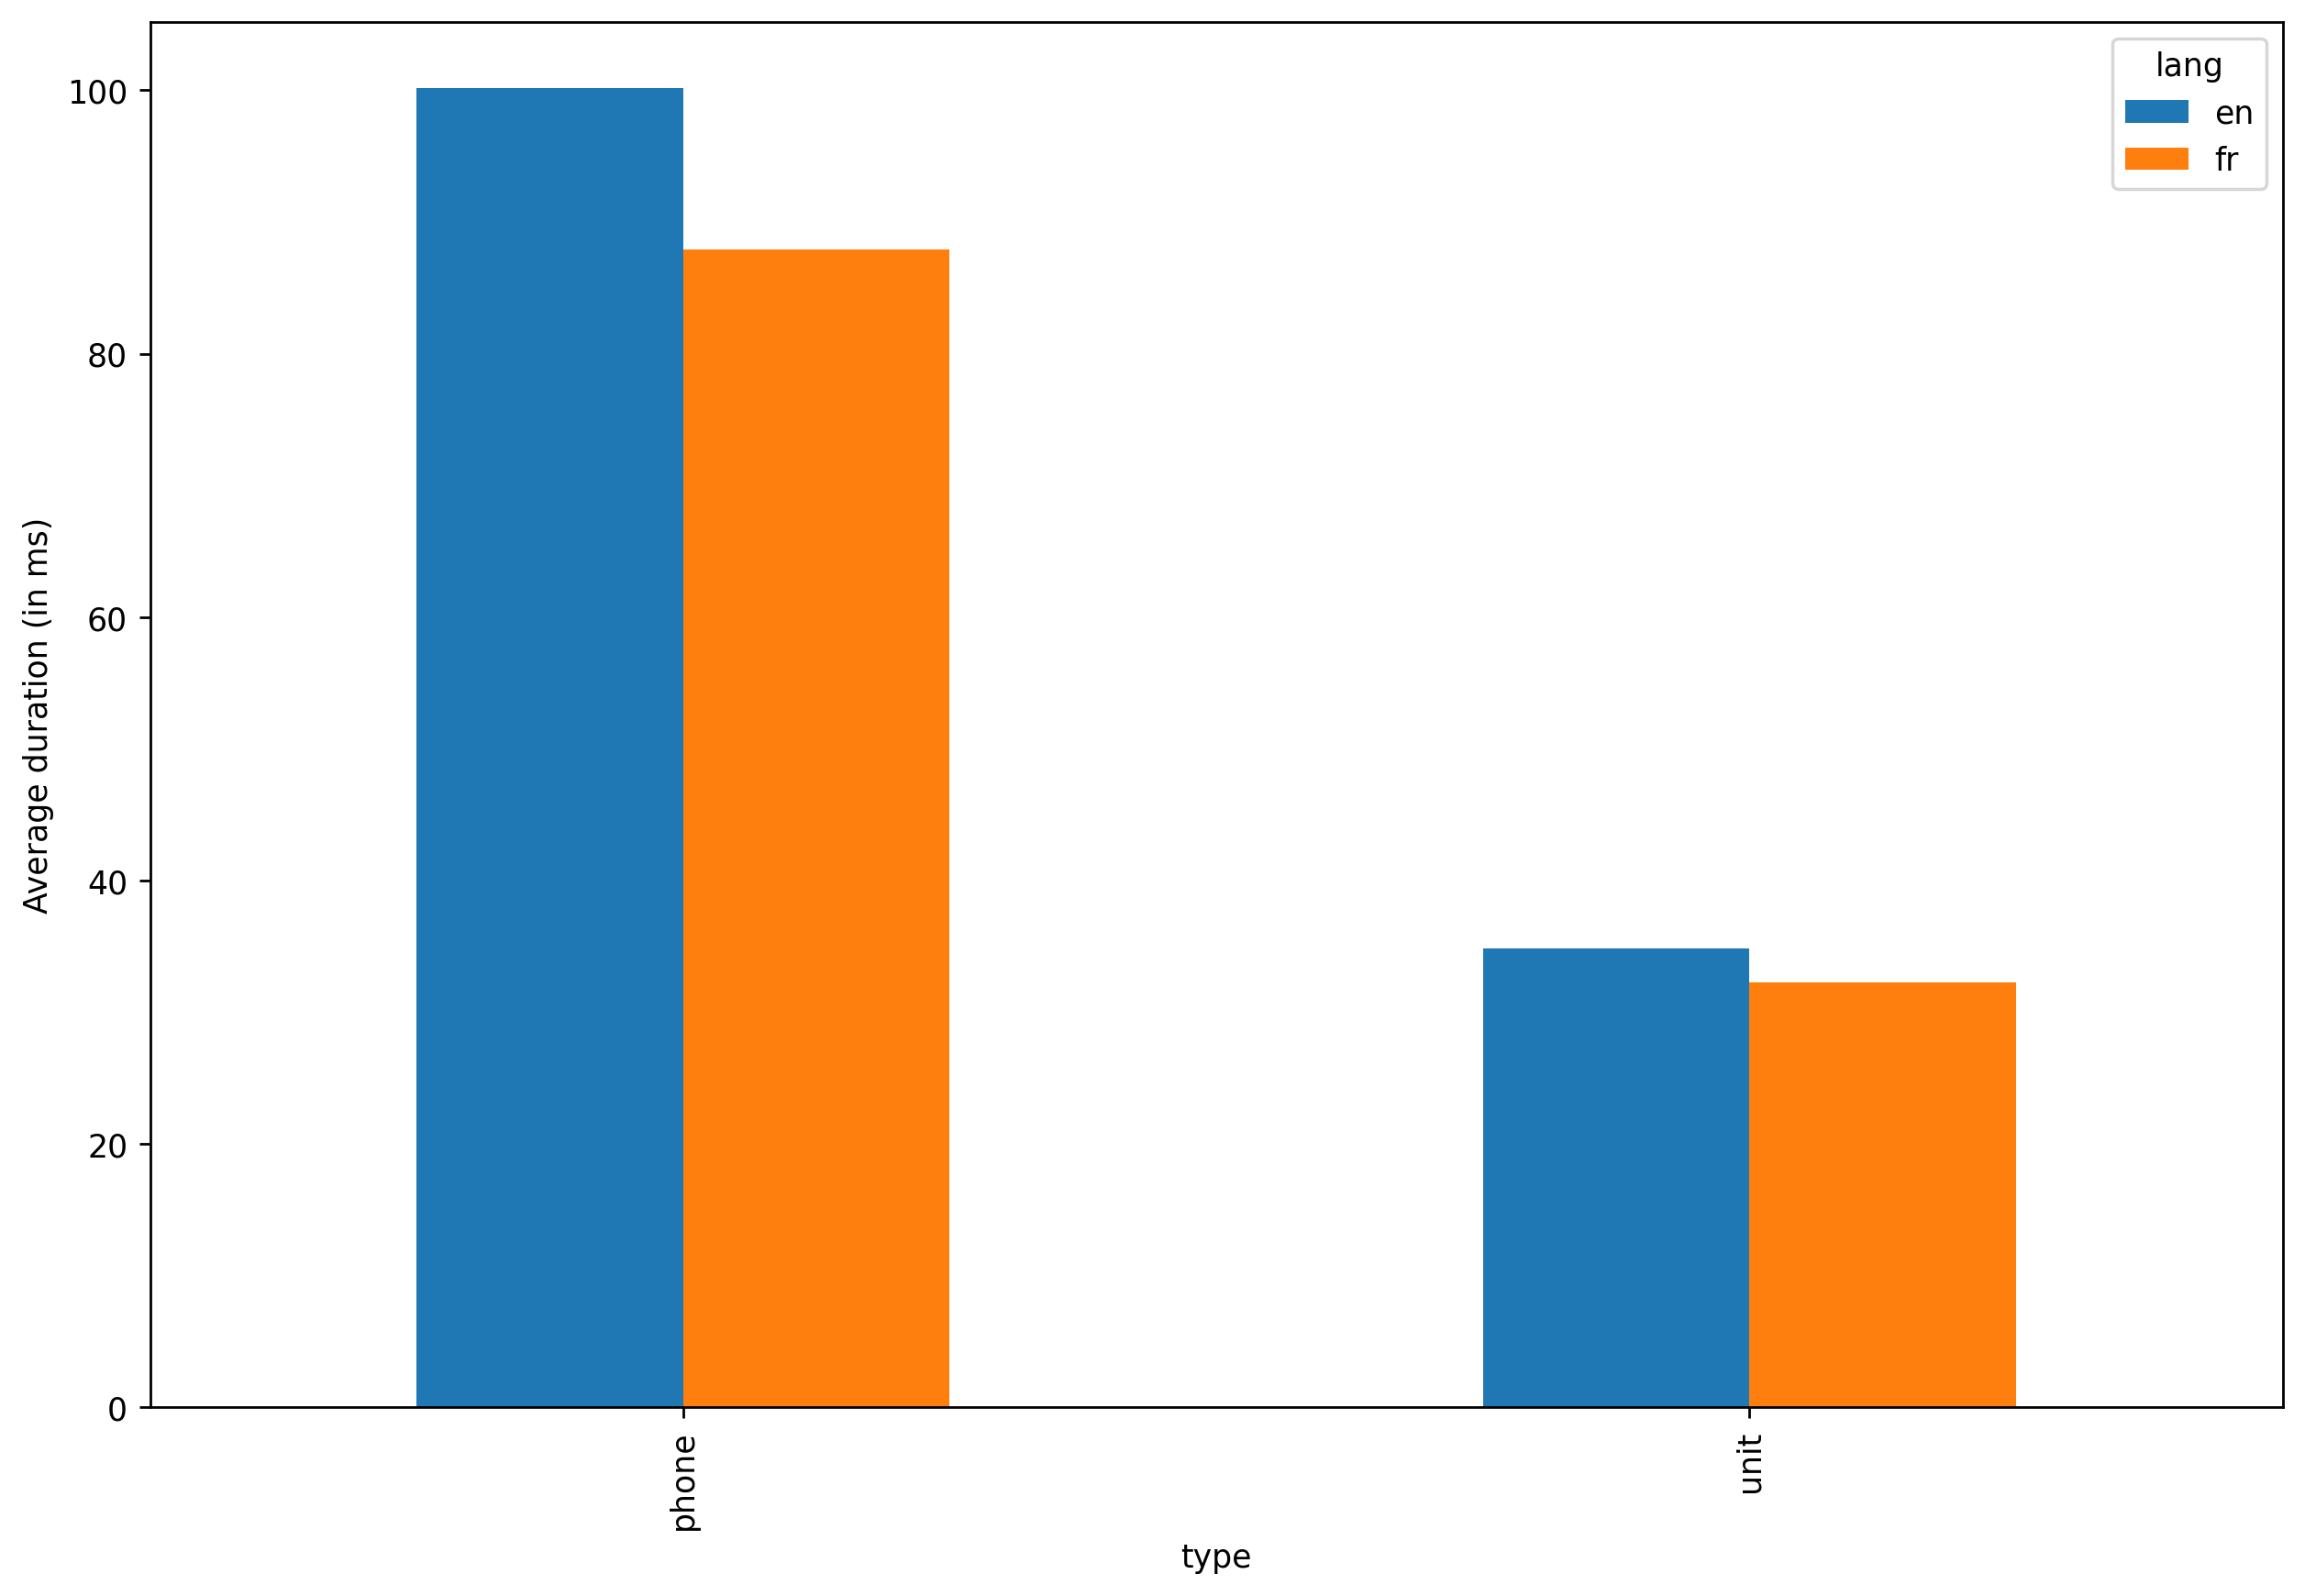

In [87]:
ax = df.groupby(by=["type", "lang"]).mean().unstack().plot.bar( y="dur_avg")
ax.set_ylabel("Average duration (in ms)")

(0.0, 53000.0)

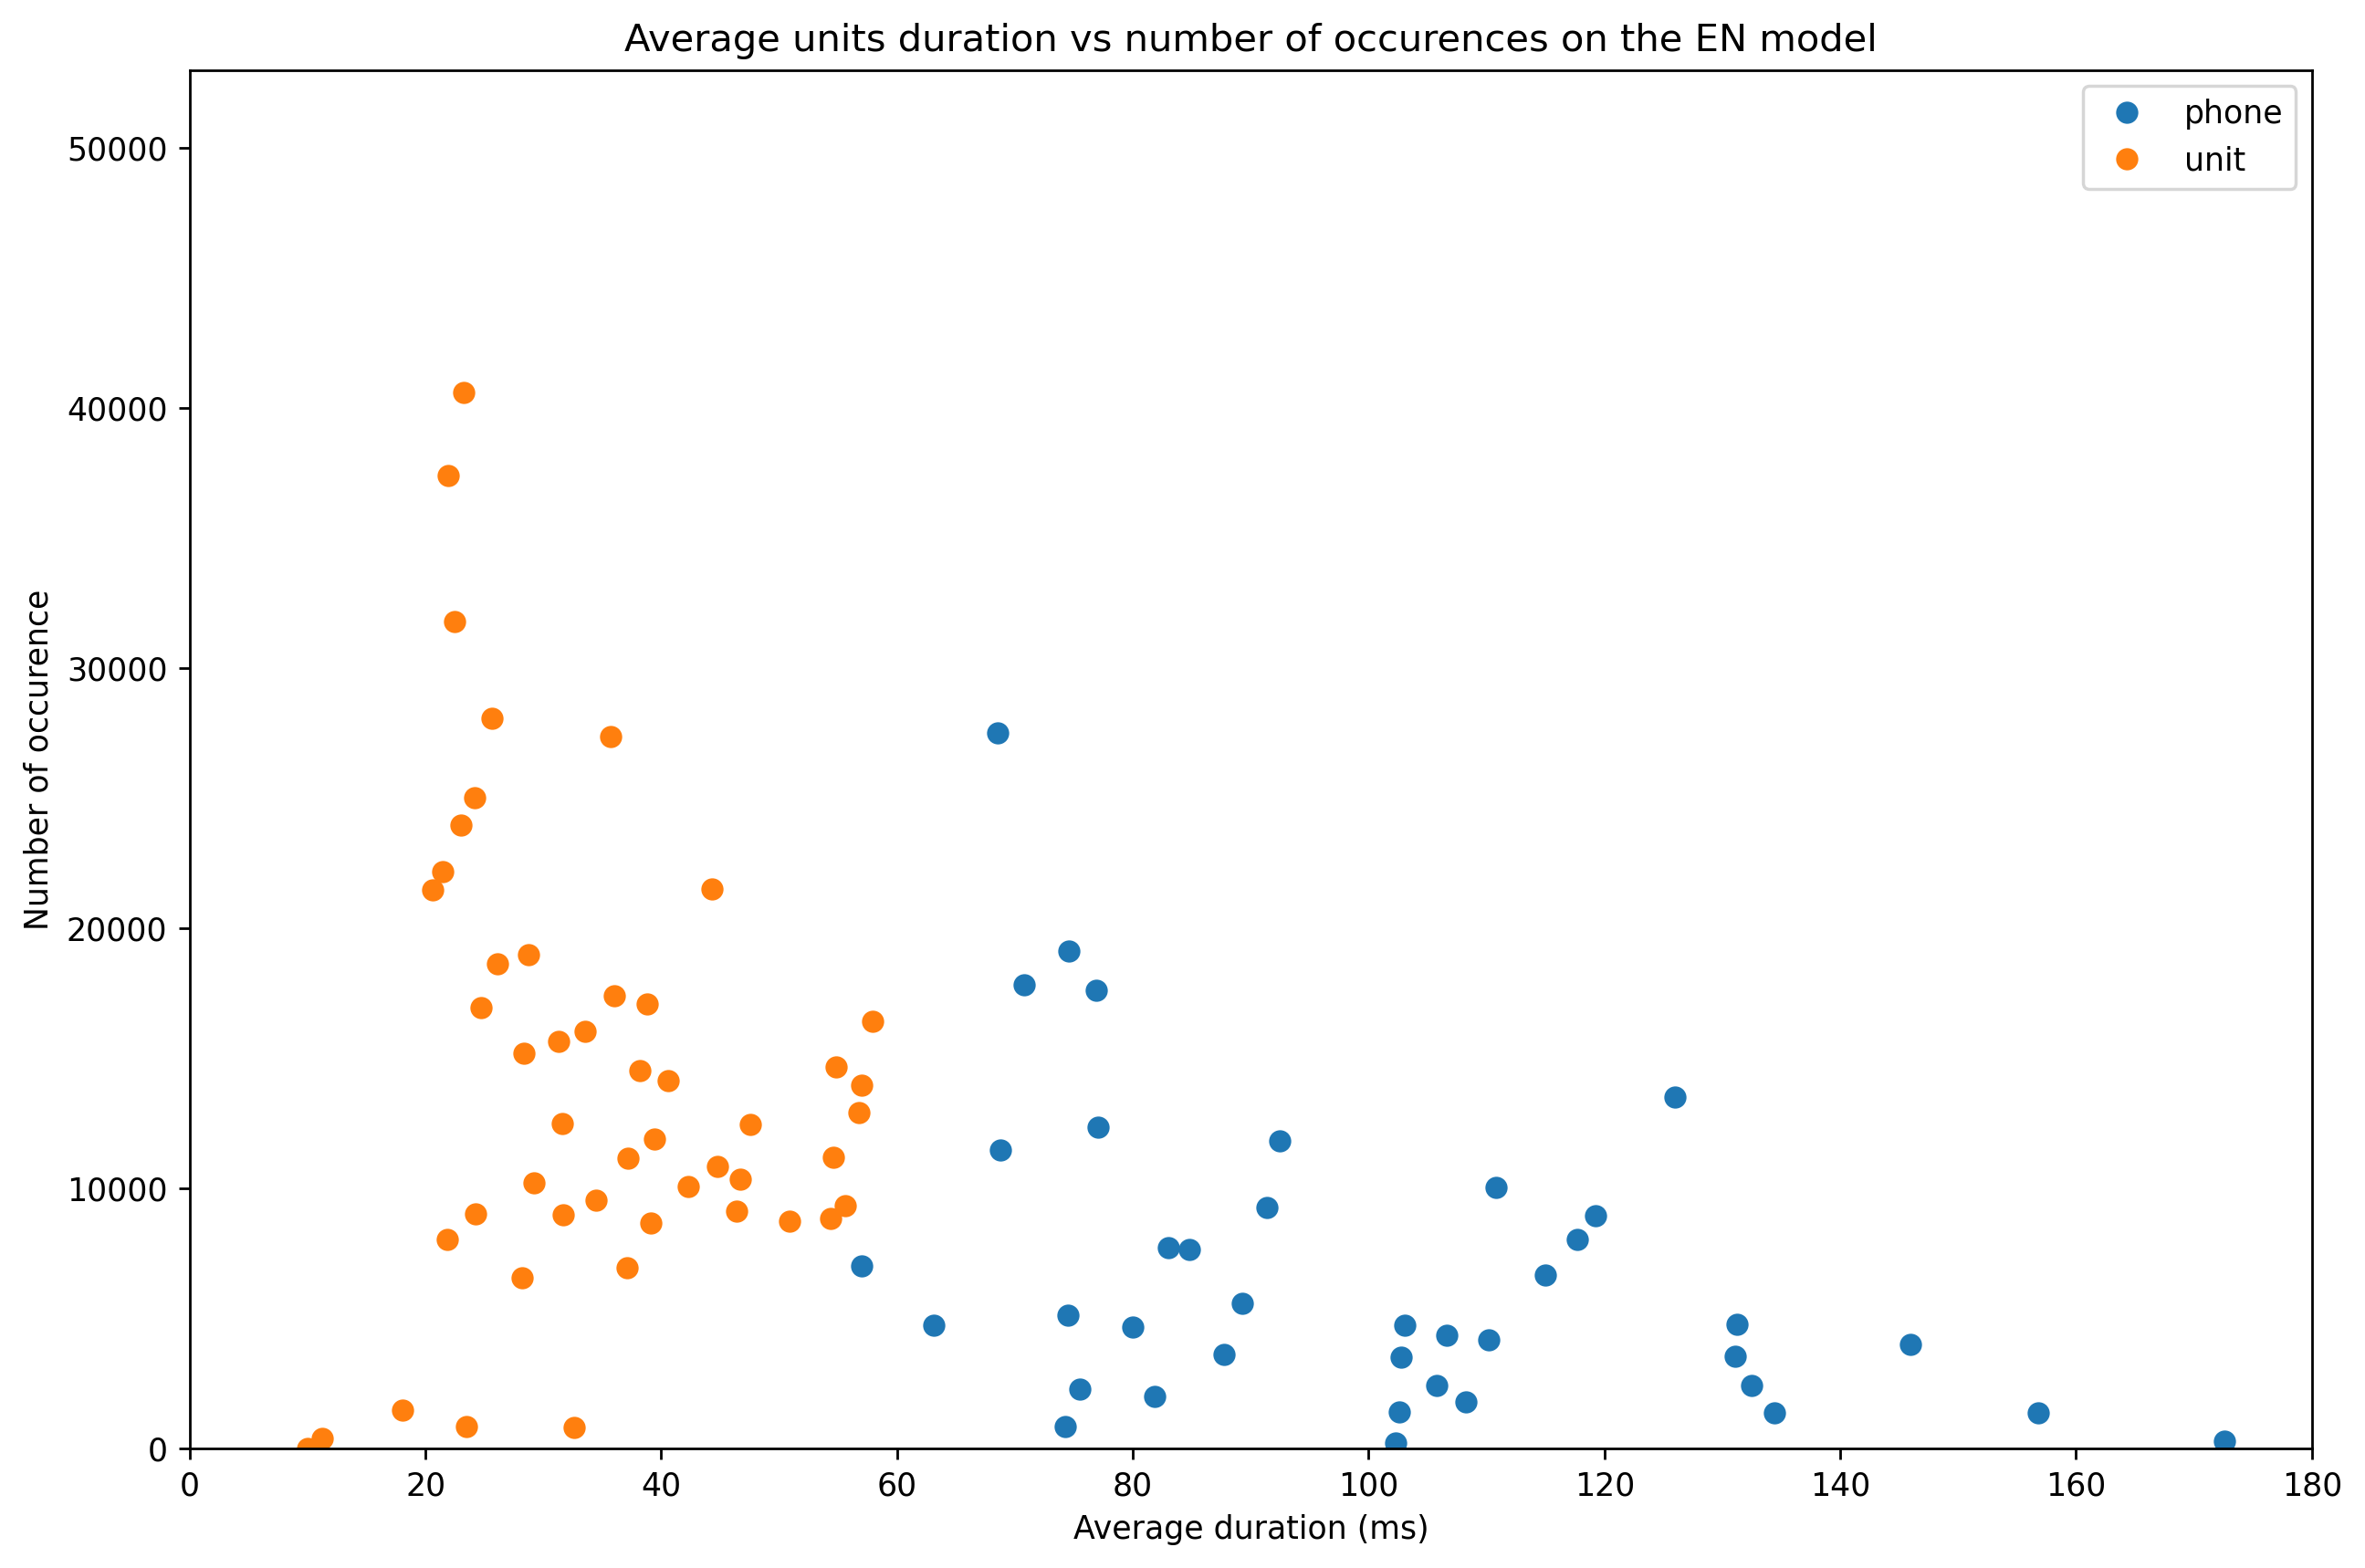

In [88]:
lang="en"
d = df_en

groups = d.groupby("type")
for name, group in groups:
    plt.plot(group["dur_avg"], group["num_items"], marker="o", linestyle="", label=name)
    
    #comment two lines below if no label on plot
    #for x,y,z in zip(group["dur_avg"], group["num_items"], group.index):
        #plt.annotate(z, (x,y), textcoords="offset points", xytext=(0,10),ha='center')
        
plt.legend()
plt.xlabel("Average duration (ms)")
plt.ylabel("Number of occurence")
plt.title("Average units duration vs number of occurences on the {} model".format(lang.upper()))

plt.xlim(0, 180)
plt.ylim(0, 53000)

(0.0, 53000.0)

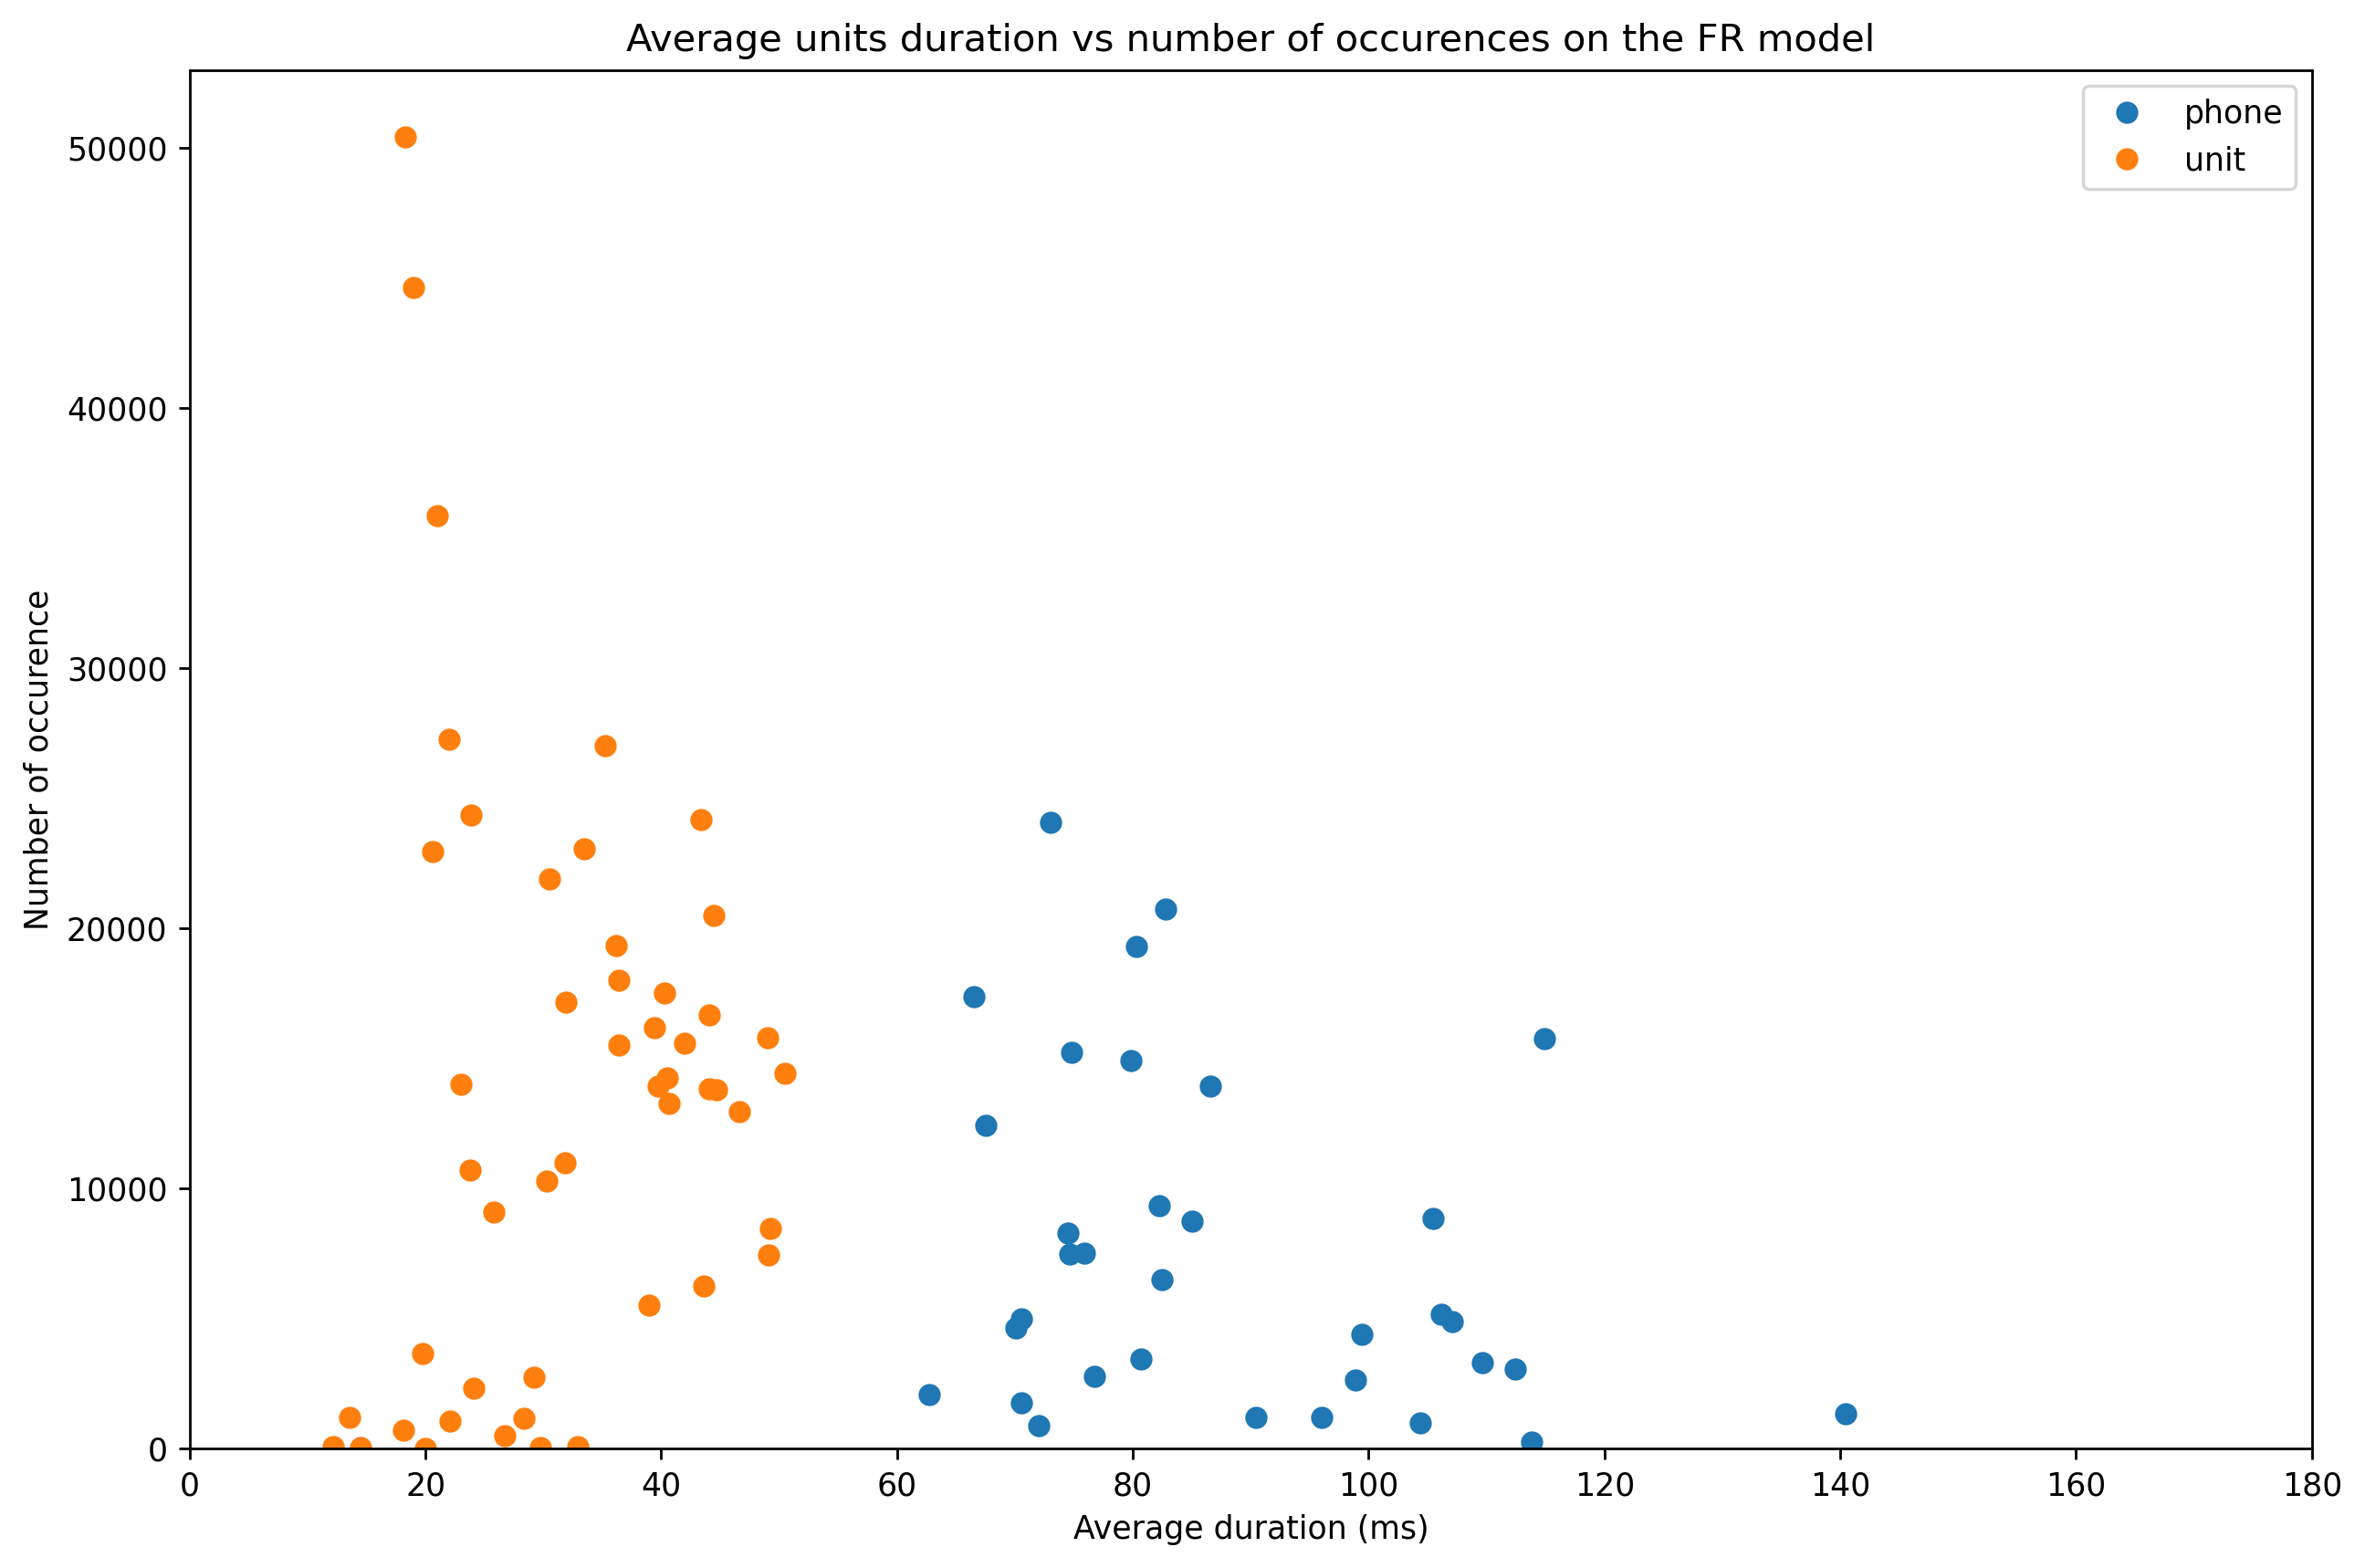

In [89]:
lang="fr"
d = df_fr

groups = d.groupby("type")
for name, group in groups:
    plt.plot(group["dur_avg"], group["num_items"], marker="o", linestyle="", label=name)
    
    #comment two lines below if no label on plot
    #for x,y,z in zip(group["dur_avg"], group["num_items"], group.index):
    #    plt.annotate(z, (x,y), textcoords="offset points", xytext=(0,10),ha='center')
        
plt.legend()
plt.xlabel("Average duration (ms)")
plt.ylabel("Number of occurence")
plt.title("Average units duration vs number of occurences on the {} model".format(lang.upper()))
plt.xlim(0, 180)
plt.ylim(0, 53000)



Text(0.5, 1.0, 'Unit distribution in terms of #occurrences for the EN model')

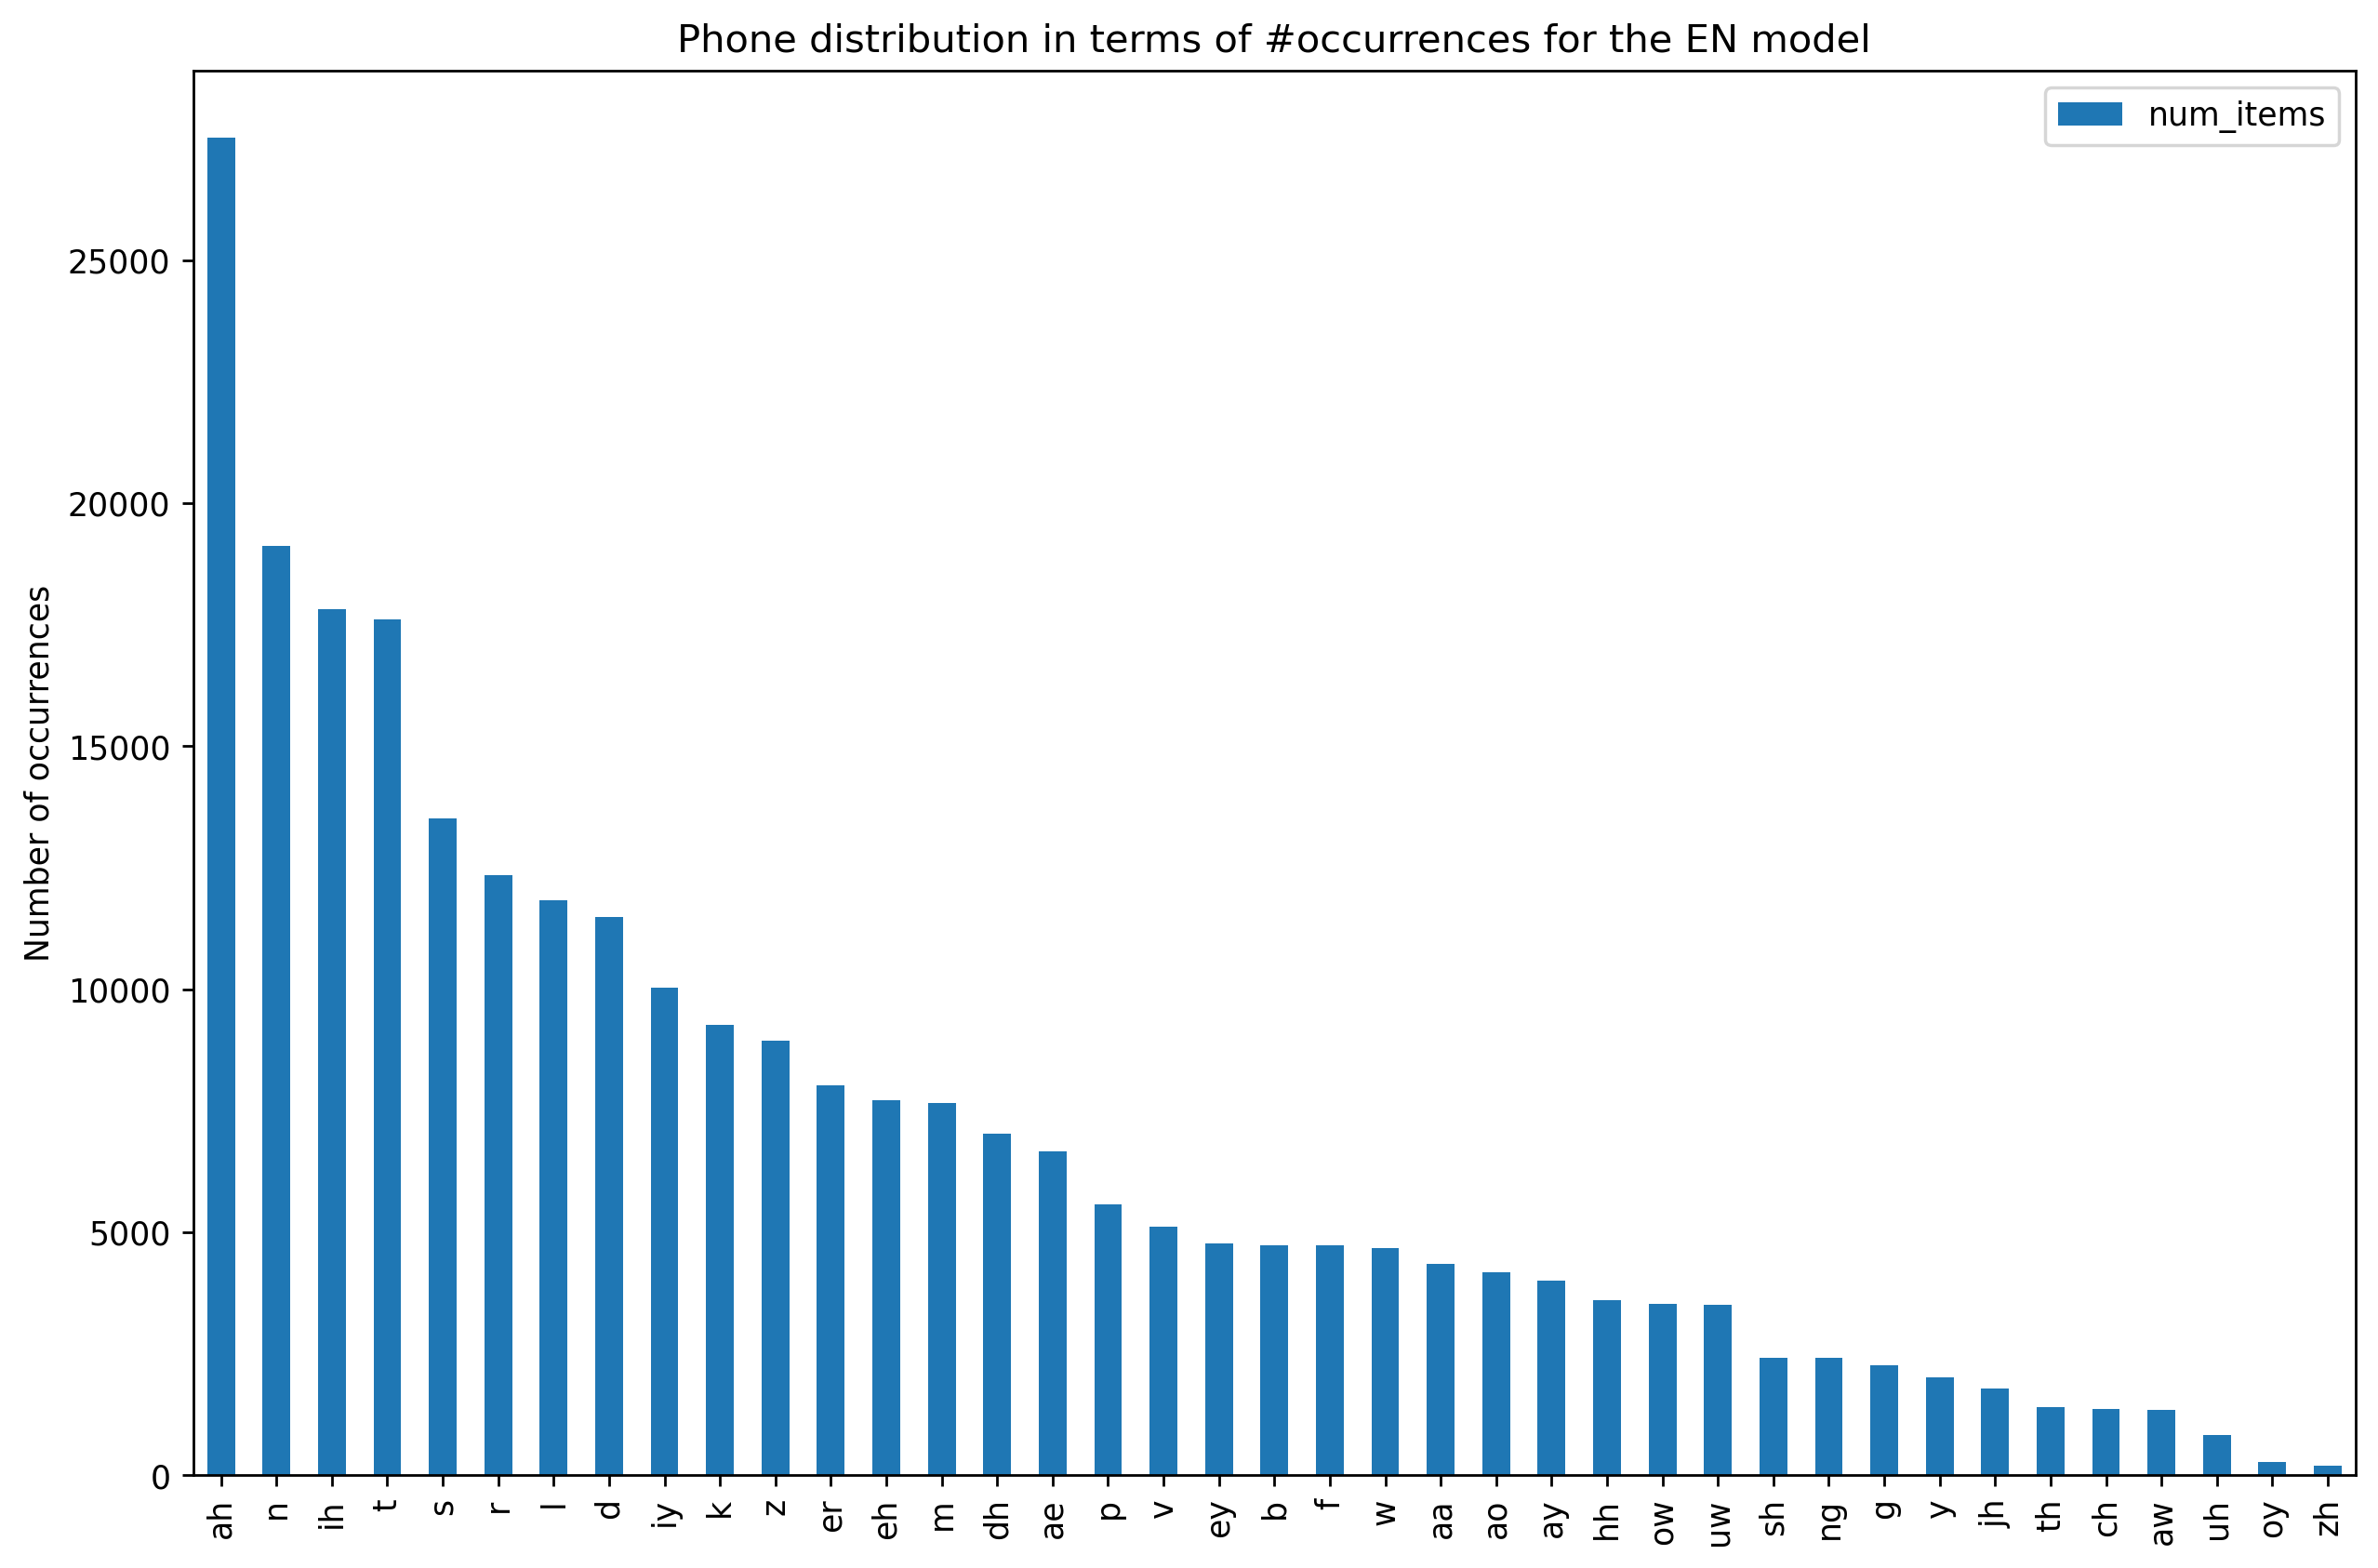

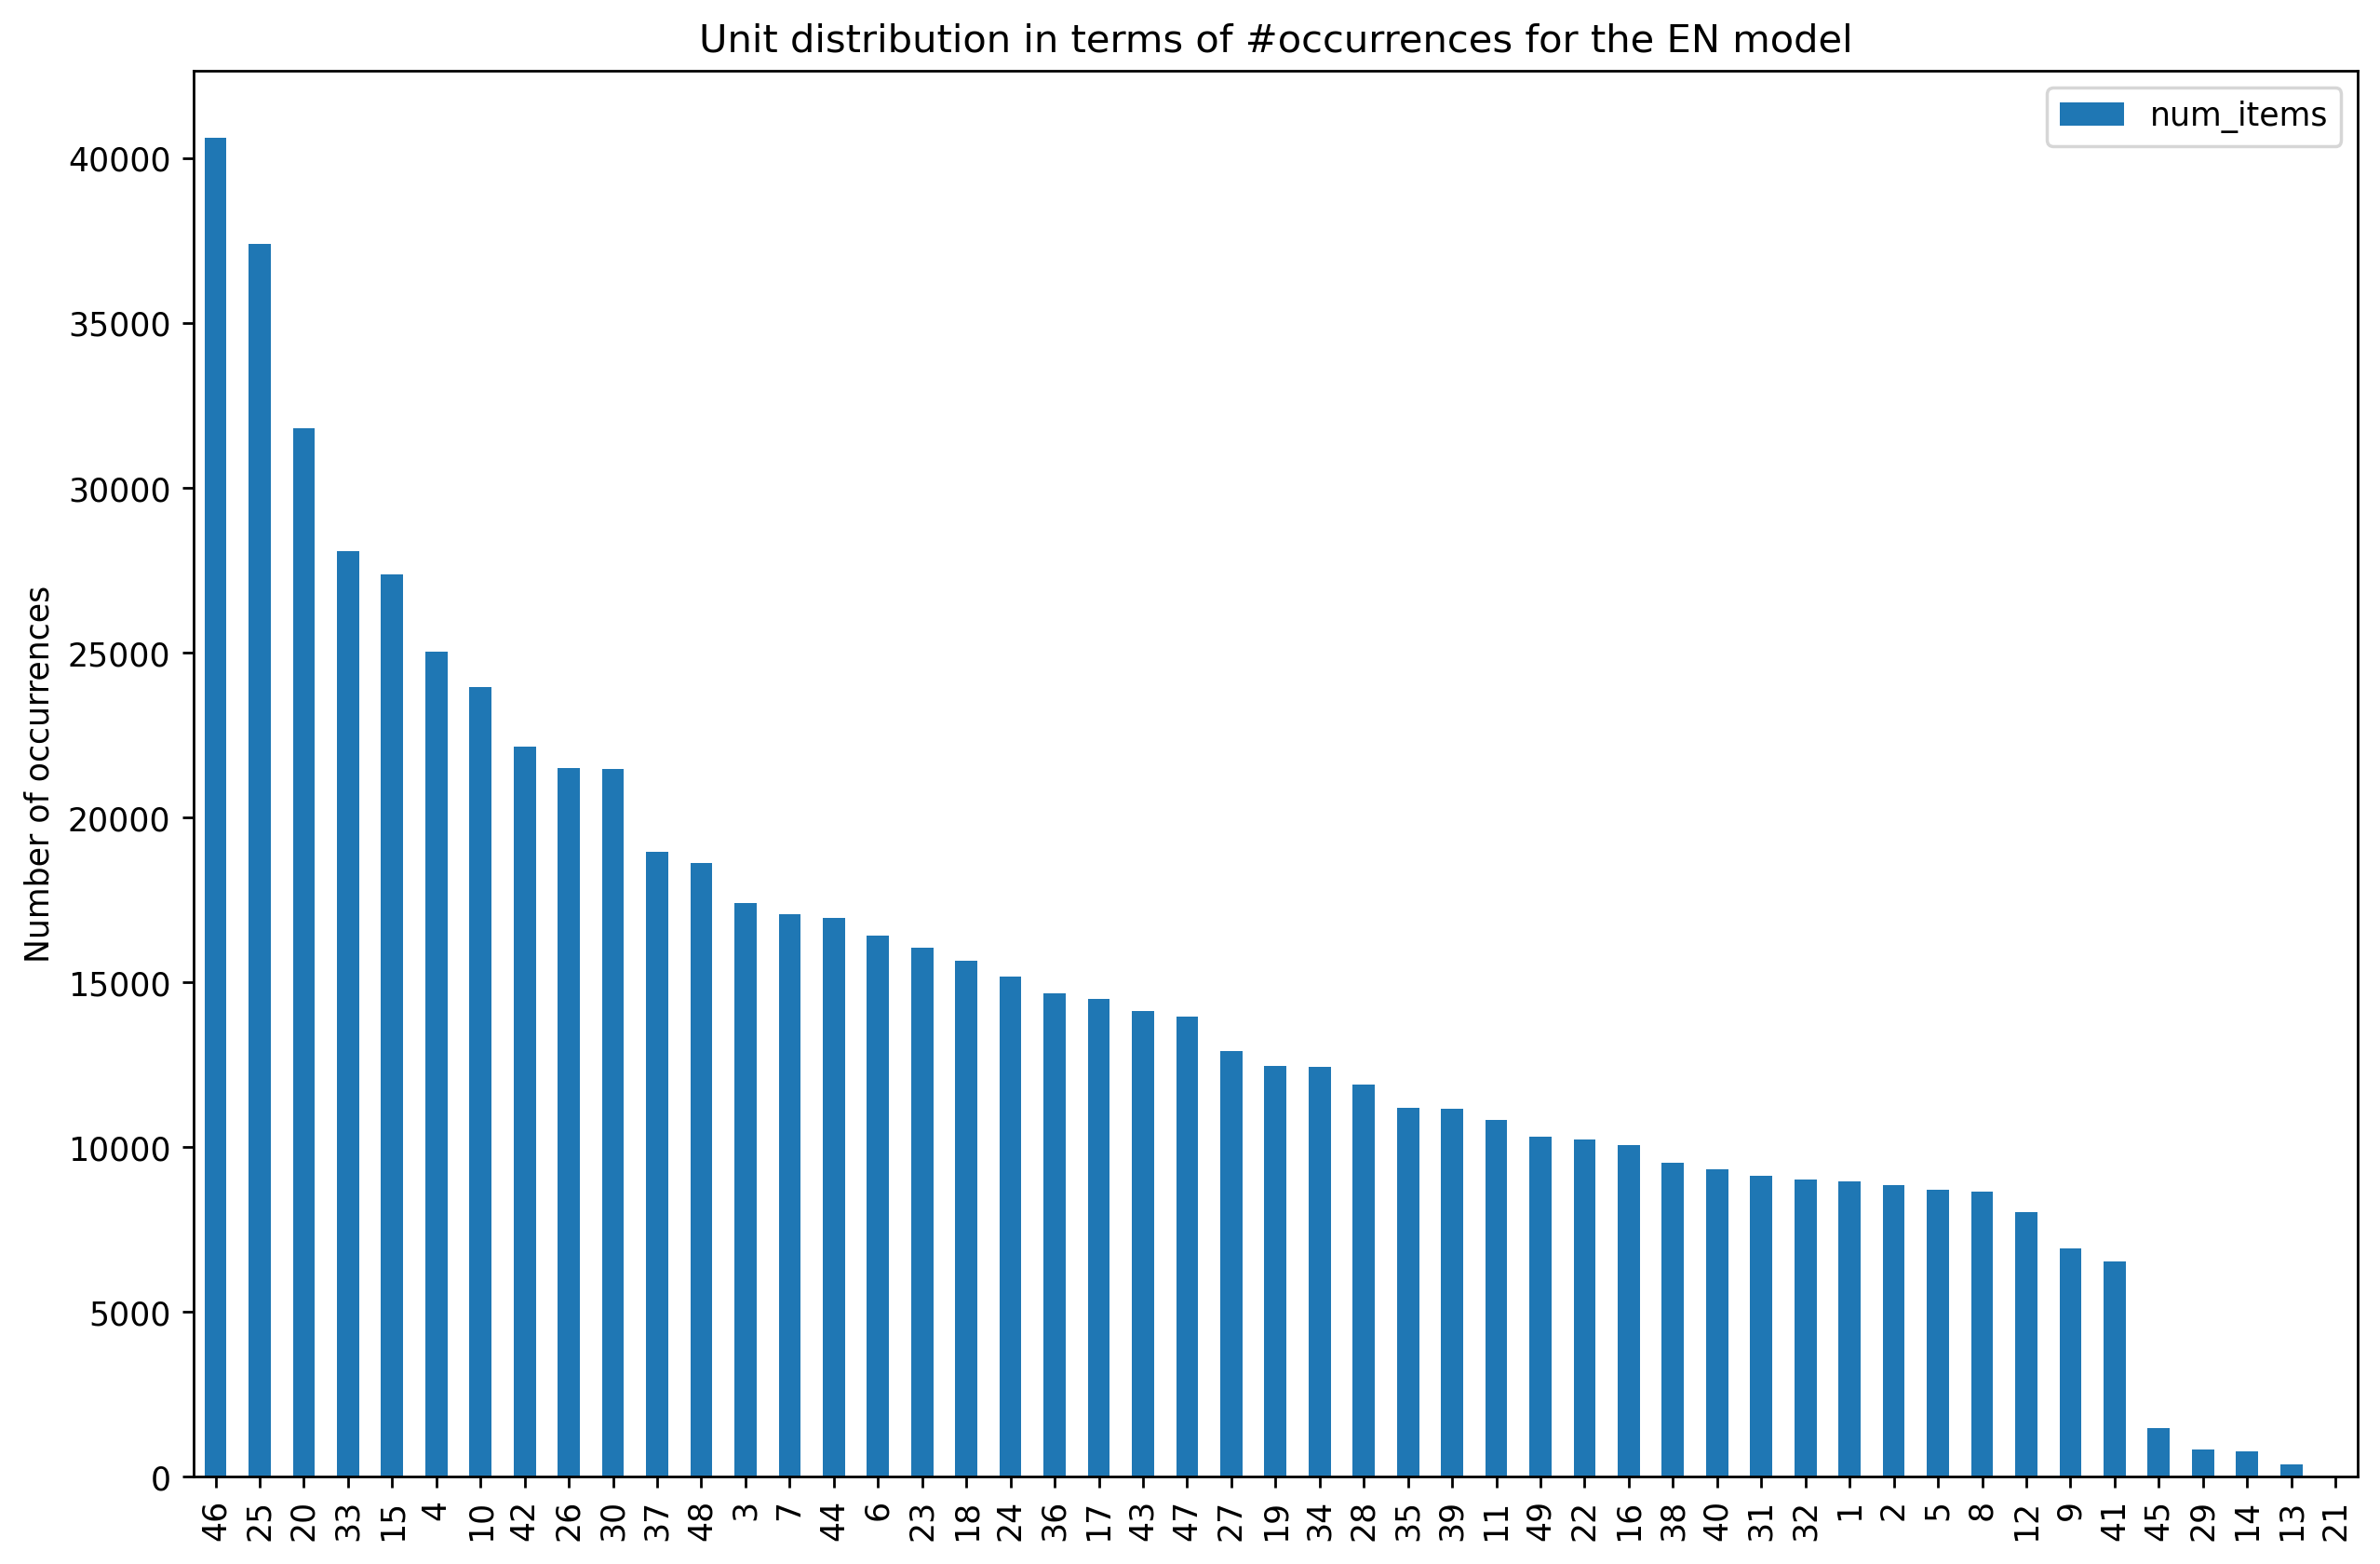

In [90]:
lang="en"
d = df_en


d[d['type']=='phone'].sort_values('num_items', ascending=False).plot.bar( y='num_items')
plt.ylabel("Number of occurrences")
plt.title('Phone distribution in terms of #occurrences for the {} model'.format(lang.upper()))

d[d['type']=='unit'].sort_values('num_items', ascending=False).plot.bar( y='num_items')
plt.ylabel("Number of occurrences")
plt.title('Unit distribution in terms of #occurrences for the {} model'.format(lang.upper()))

Text(0.5, 1.0, 'Unit distribution in terms of #occurrences for the FR model')

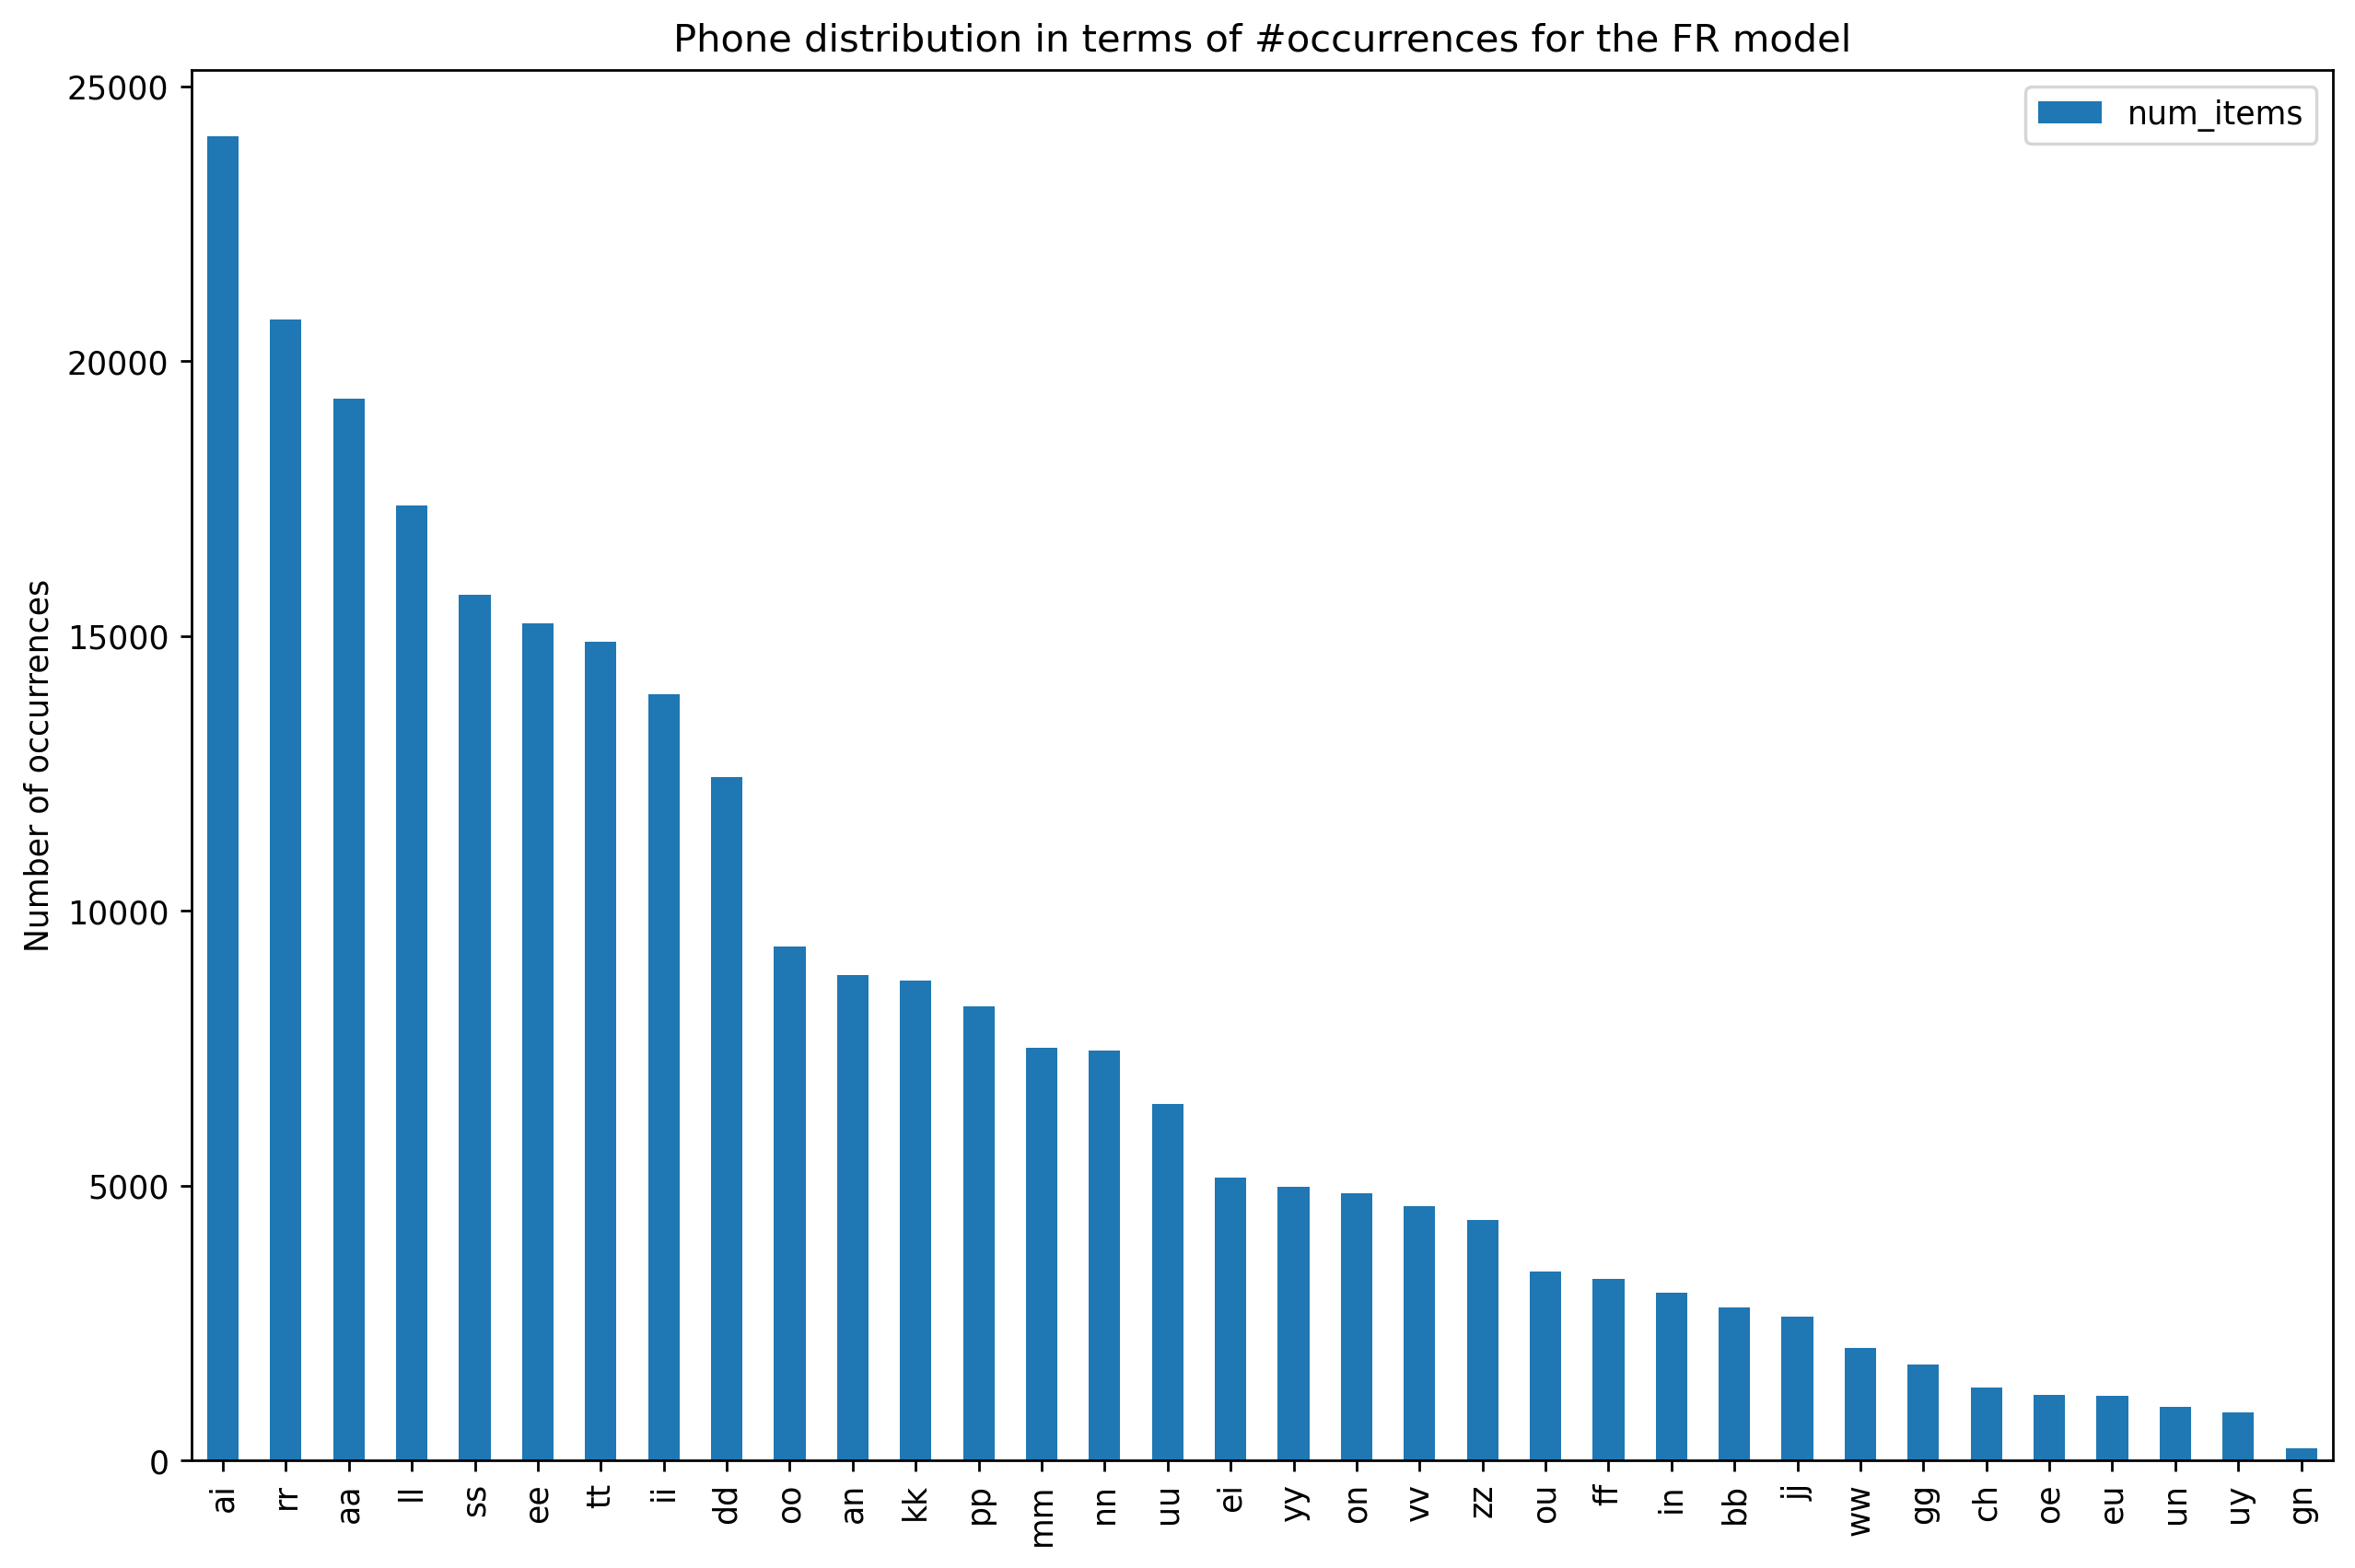

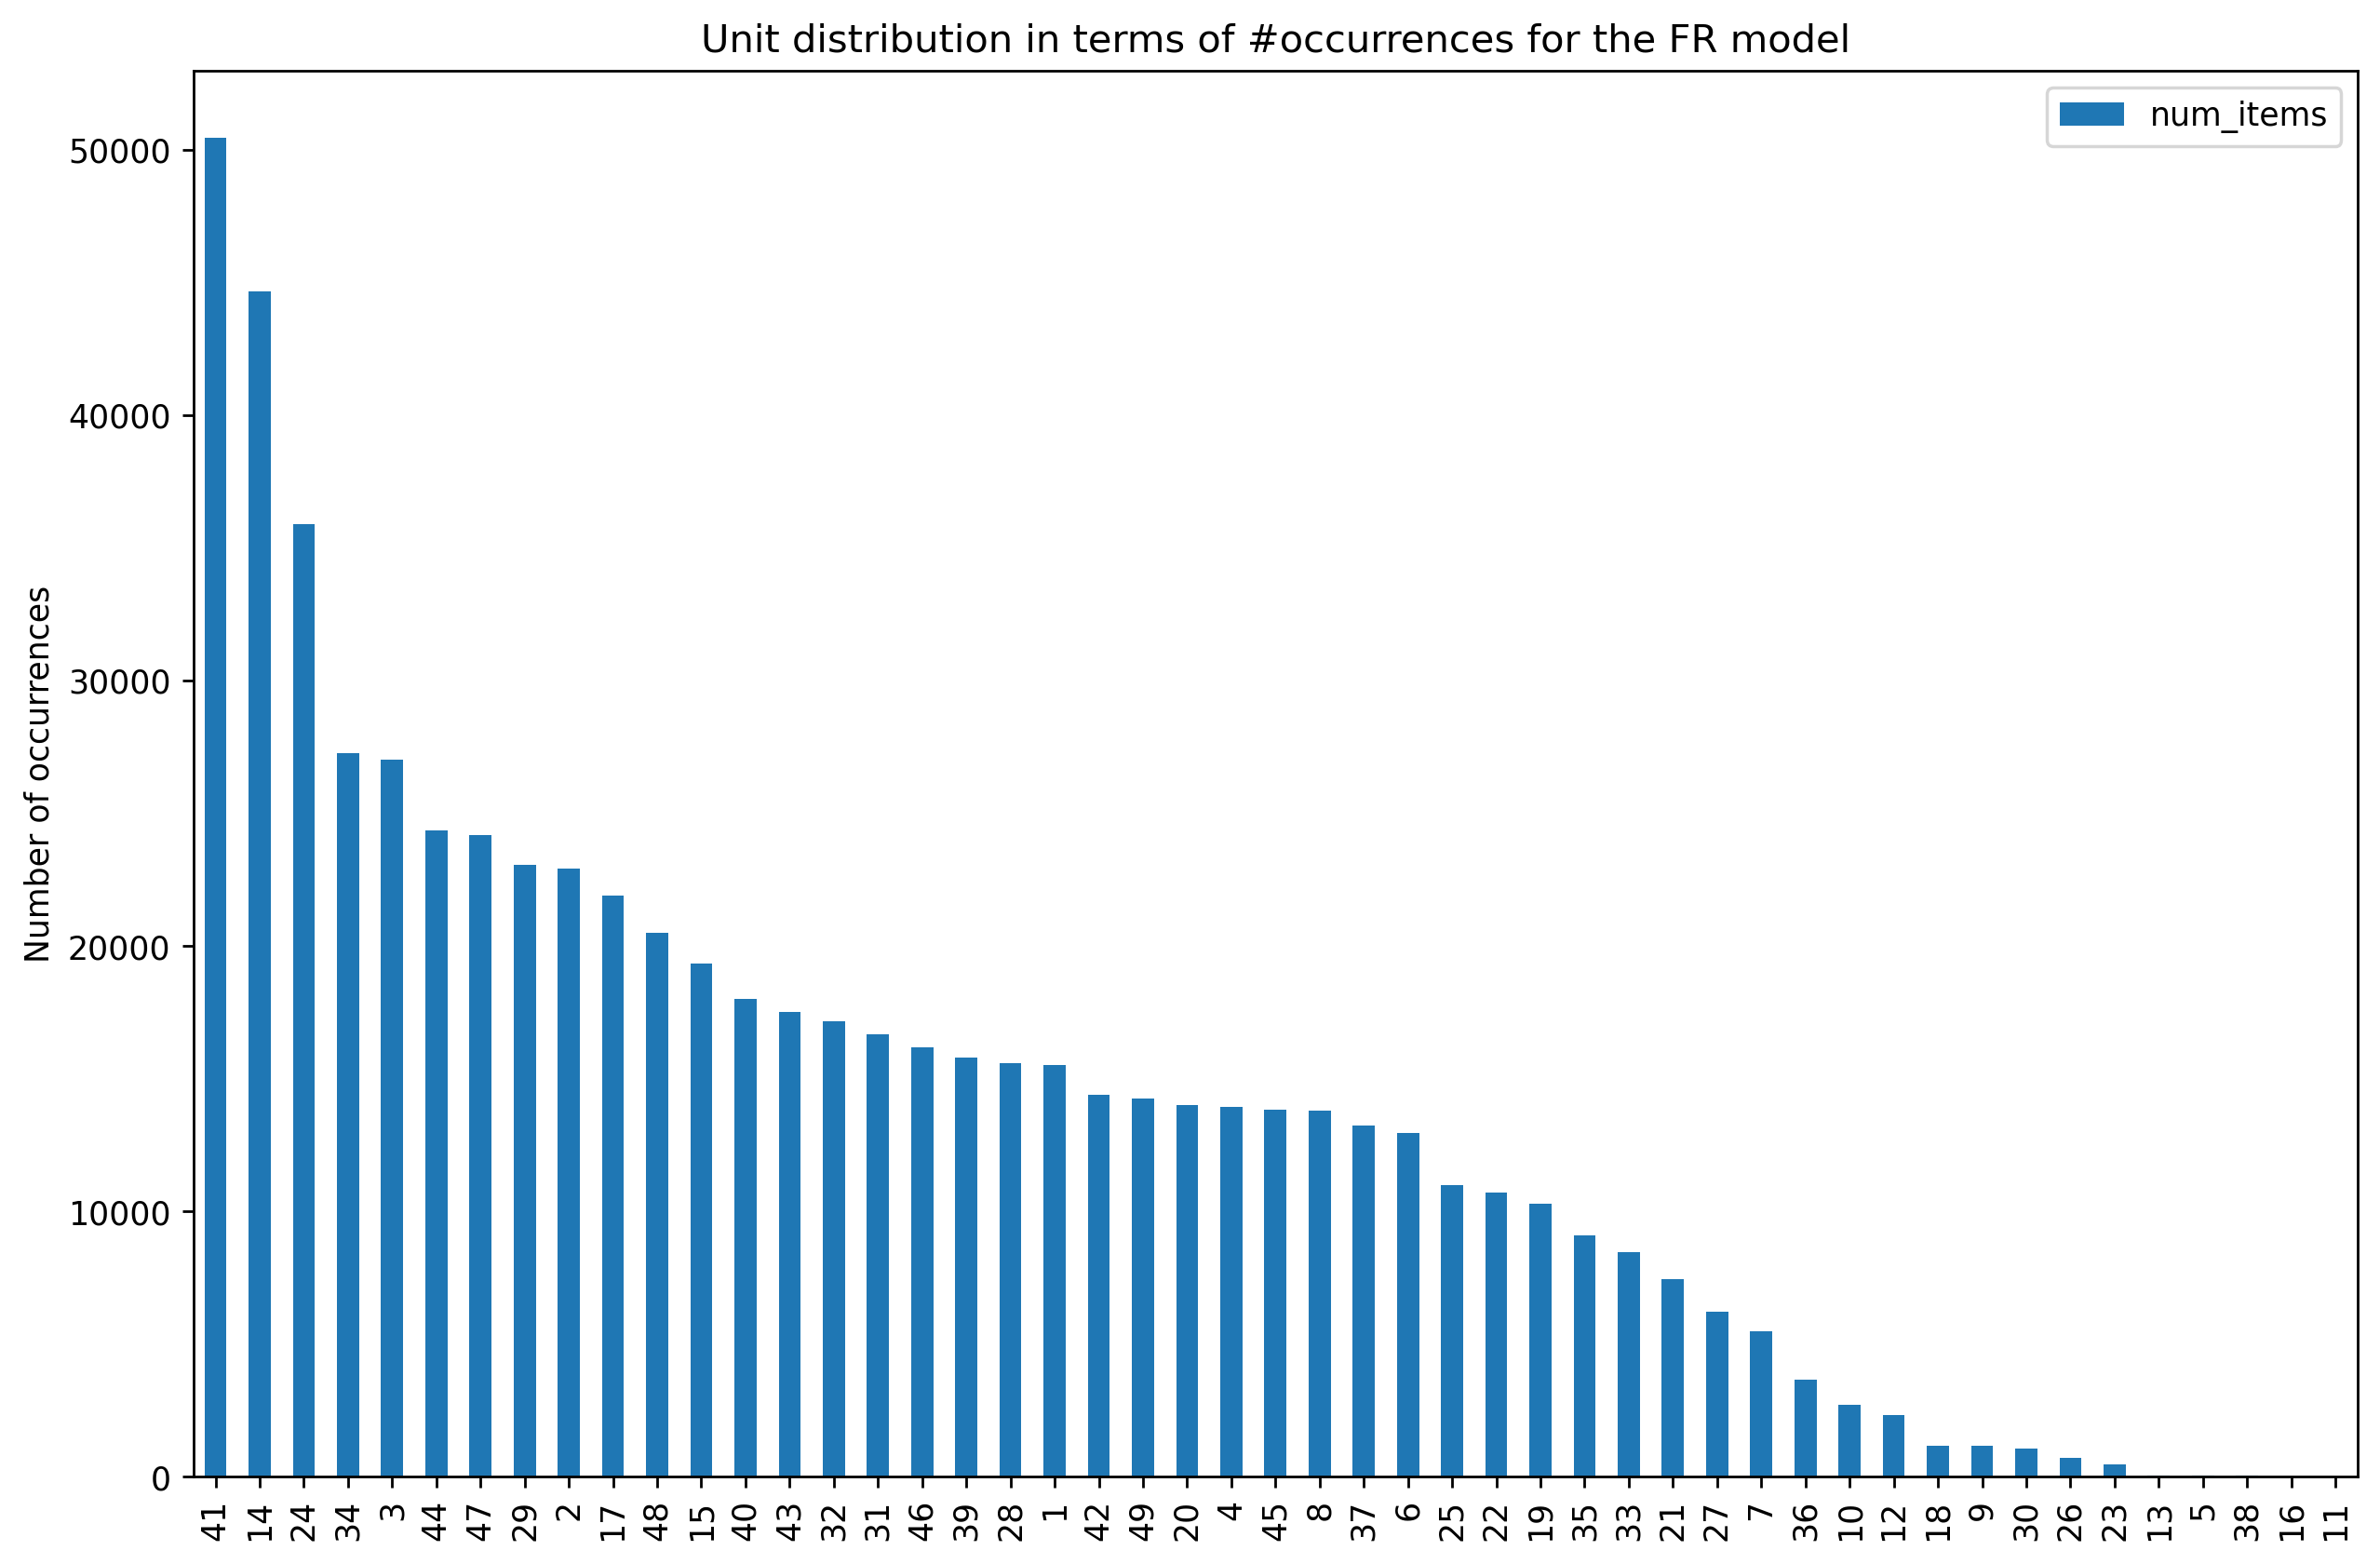

In [91]:
lang="fr"
d = df_fr

d[d['type']=='phone'].sort_values('num_items', ascending=False).plot.bar( y='num_items')
plt.ylabel("Number of occurrences")
plt.title('Phone distribution in terms of #occurrences for the {} model'.format(lang.upper()))

d[d['type']=='unit'].sort_values('num_items', ascending=False).plot.bar( y='num_items')
plt.ylabel("Number of occurrences")
plt.title('Unit distribution in terms of #occurrences for the {} model'.format(lang.upper()))

(0.0, 210000.0)

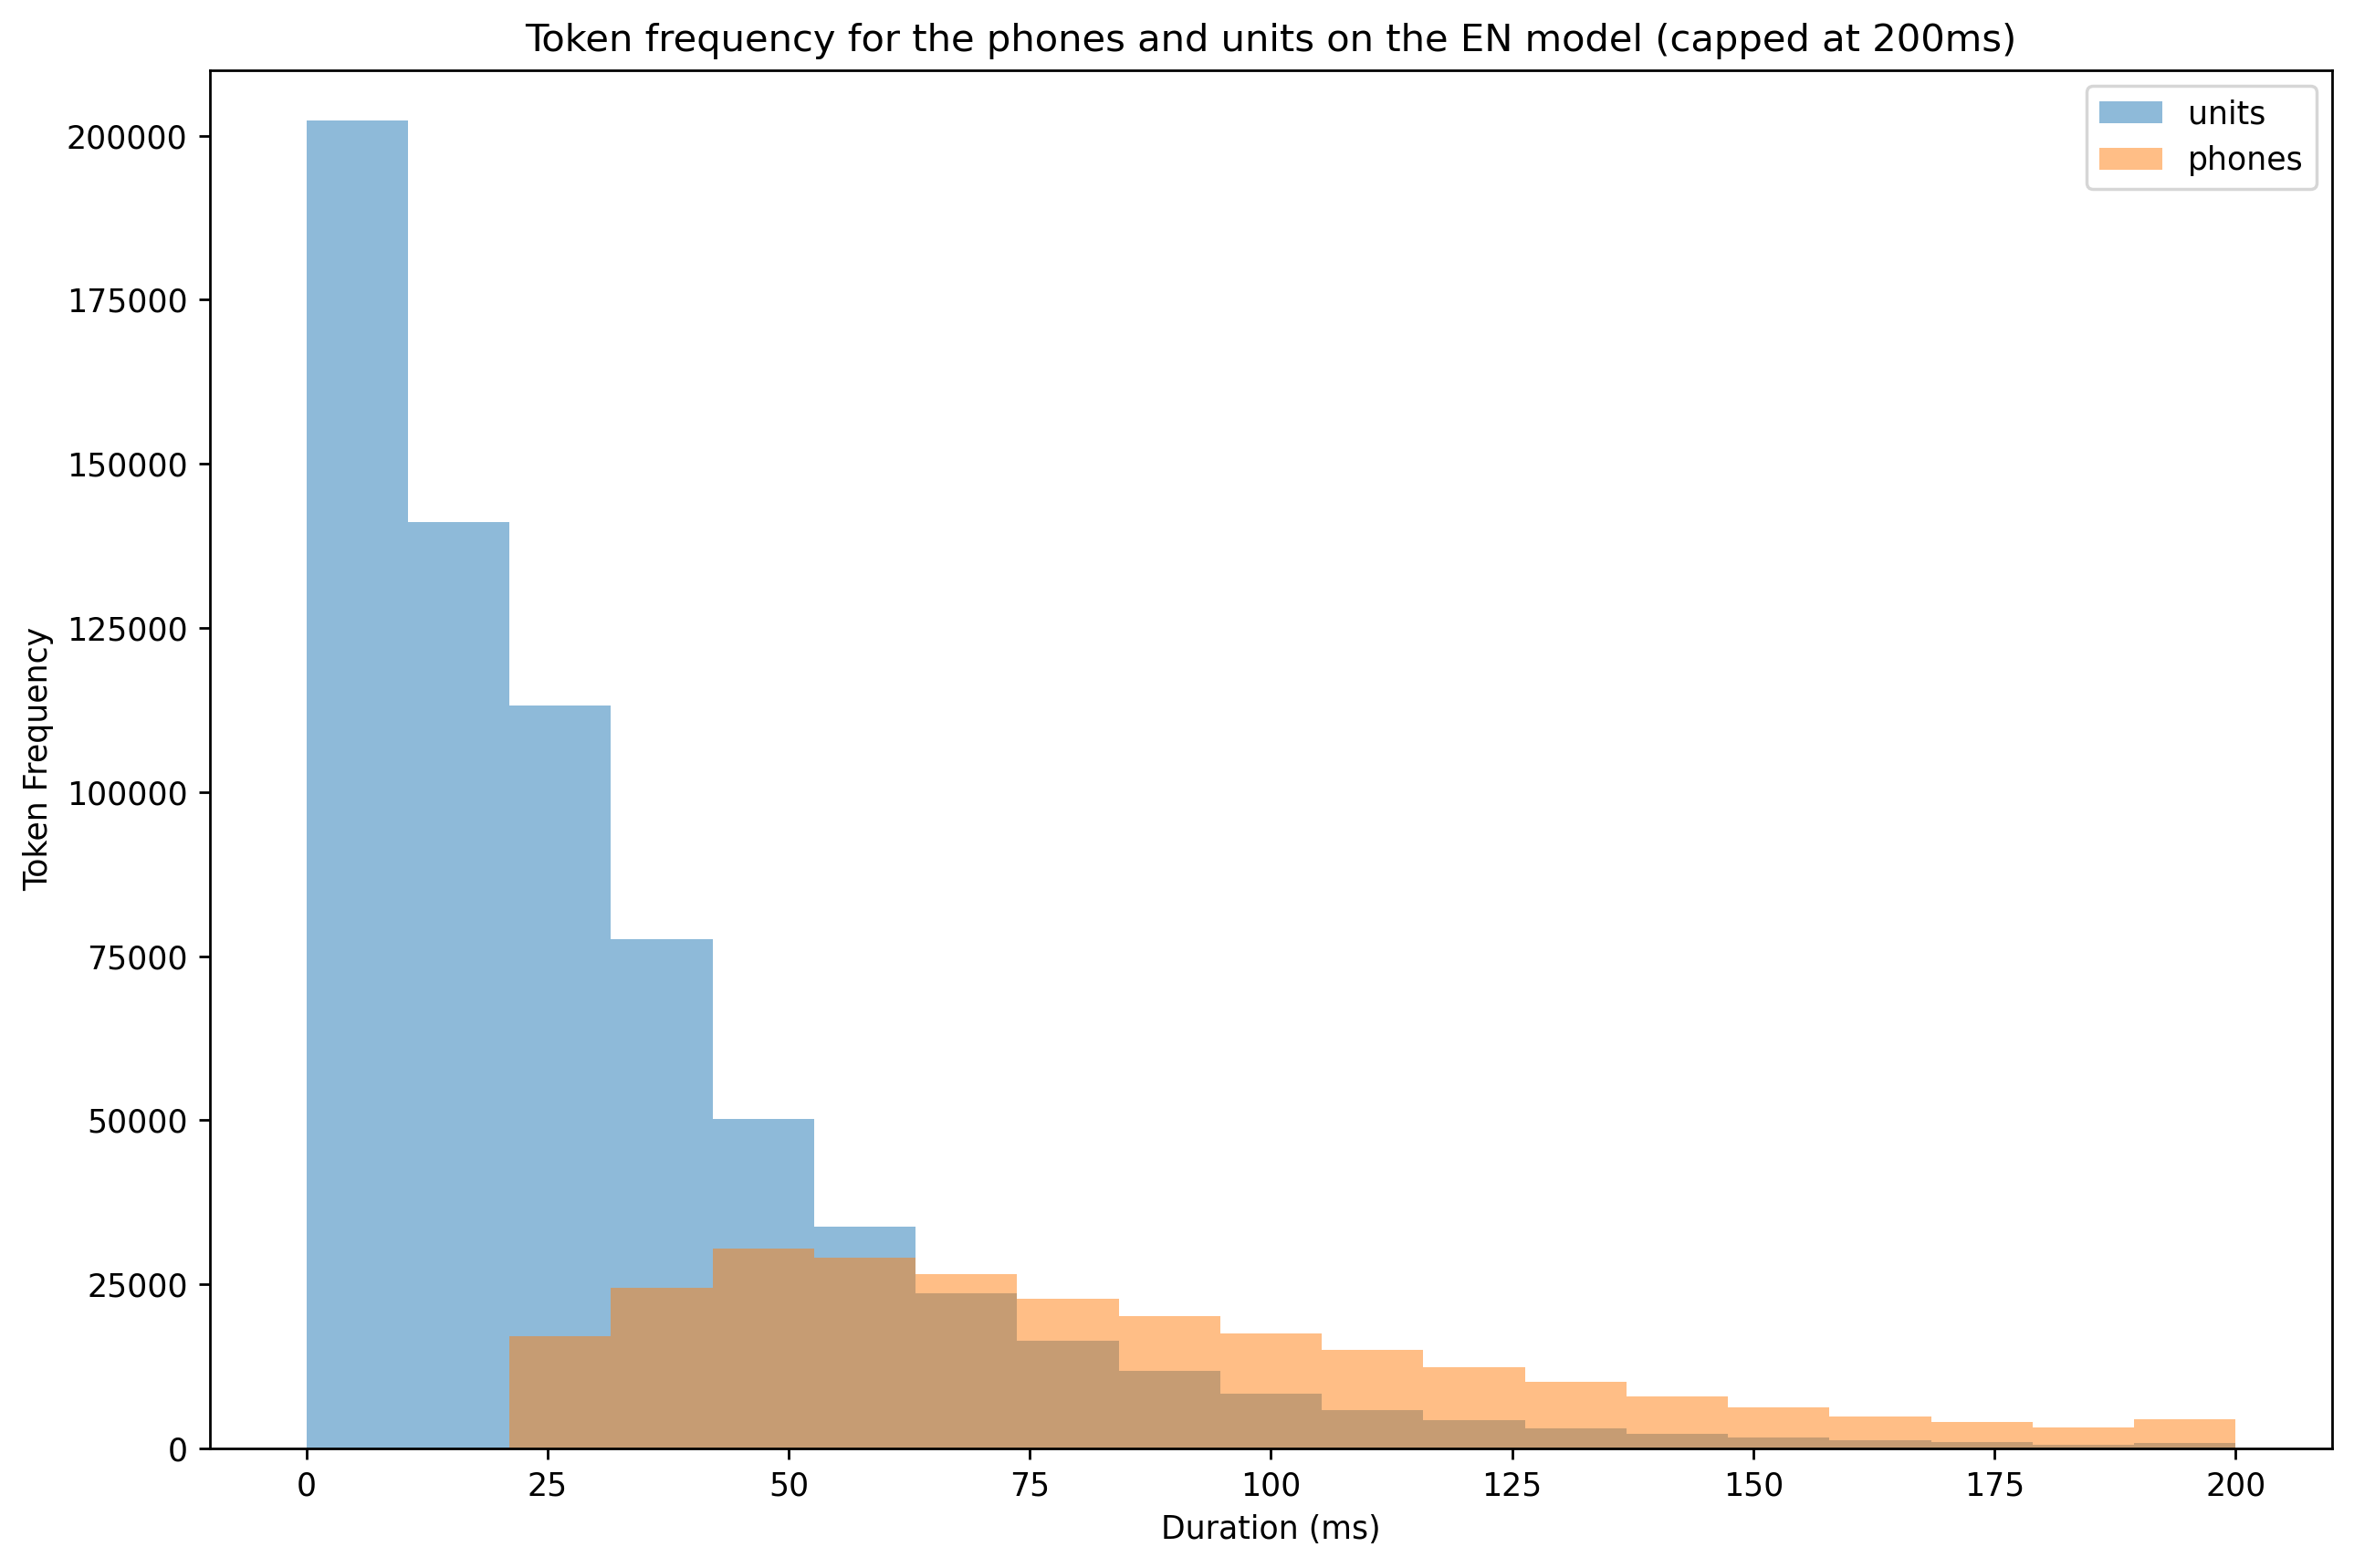

In [92]:
lang="en"
d_full = df_full_en

bins = np.linspace(0, 200, 20)

plt.hist(d_full[d_full['type']=="unit"]["dur"], bins, alpha=0.5, label='units')
plt.hist(d_full[d_full['type']=="phone"]["dur"], bins, alpha=0.5, label='phones')
plt.legend(loc='upper right')
plt.xlabel("Duration (ms)")
plt.ylabel("Token Frequency")
plt.title('Token frequency for the phones and units on the {} model (capped at 200ms)'.format(lang.upper()))
plt.ylim(0, 210000)

(0.0, 210000.0)

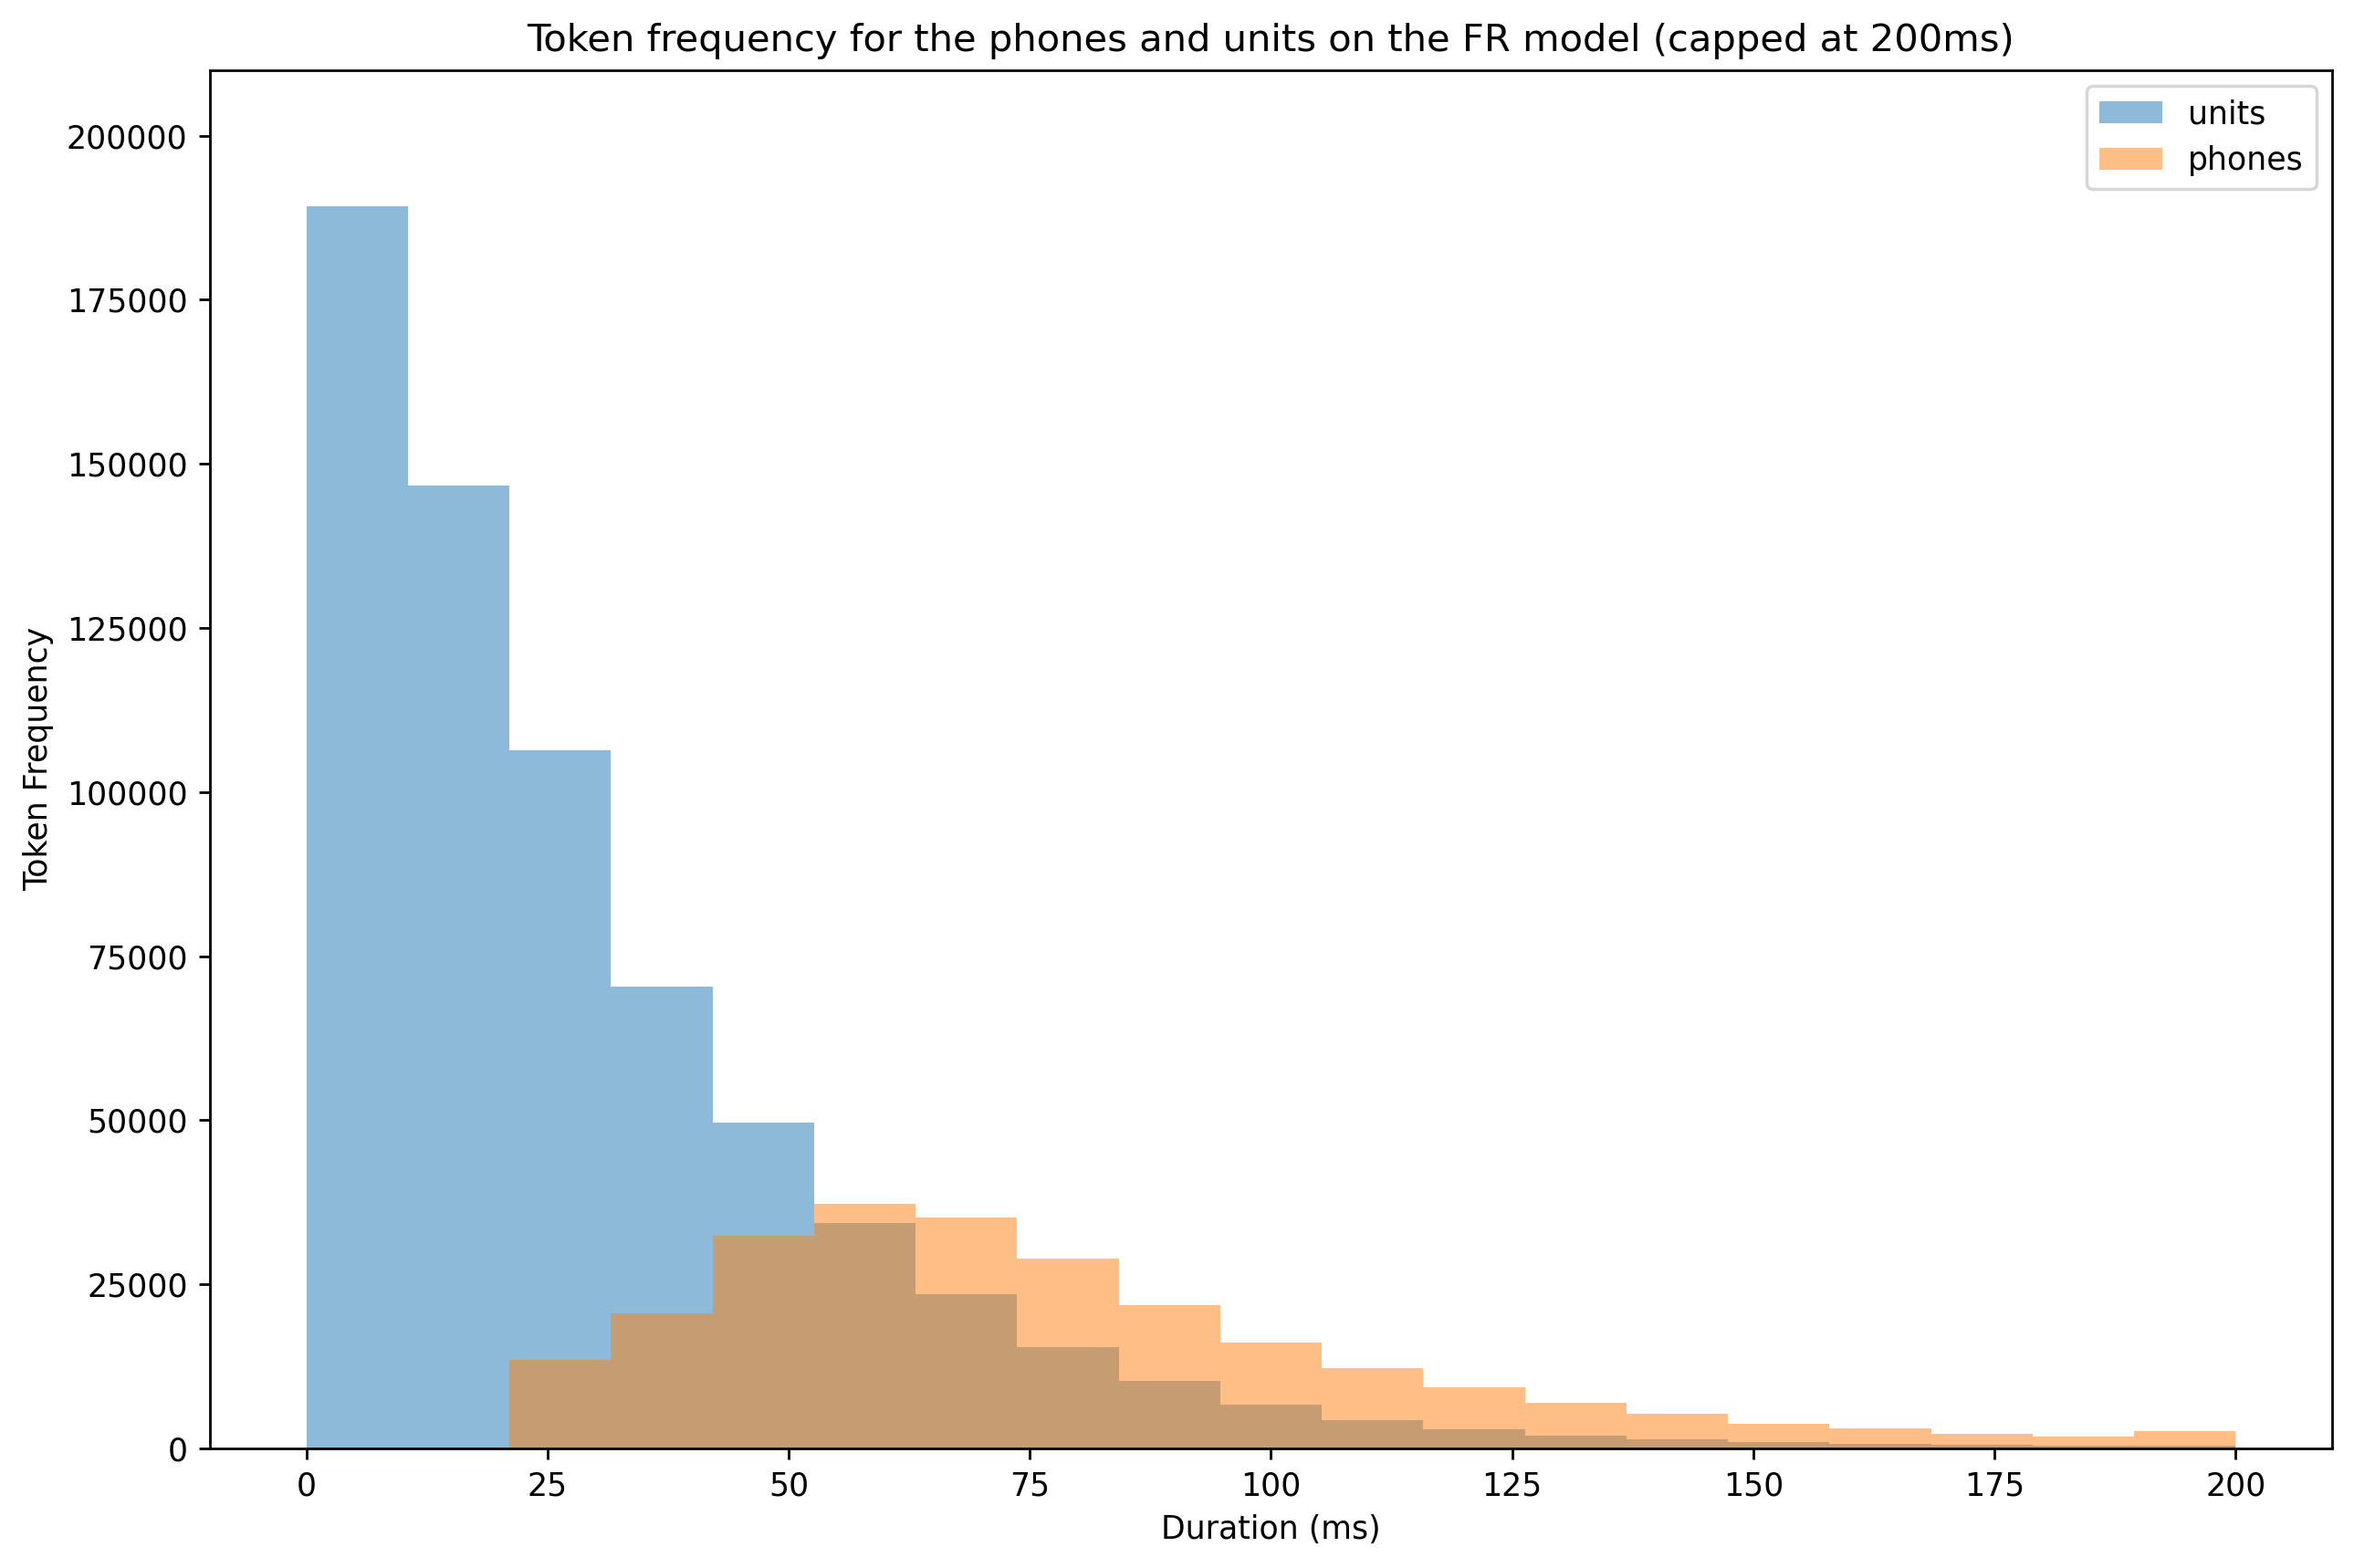

In [94]:
lang="fr"
d_full = df_full_fr

bins = np.linspace(0, 200, 20)

plt.hist(d_full[d_full['type']=="unit"]["dur"], bins, alpha=0.5, label='units')
plt.hist(d_full[d_full['type']=="phone"]["dur"], bins, alpha=0.5, label='phones')
plt.legend(loc='upper right')
plt.xlabel("Duration (ms)")
plt.ylabel("Token Frequency")
plt.title('Token frequency for the phones and units on the {} model (capped at 200ms)'.format(lang.upper()))
plt.ylim(0, 210000)

Text(0.5, 1.0, 'Distribution of token average duration for the phones and kmeans units (upper 3 percentiles hidden)')

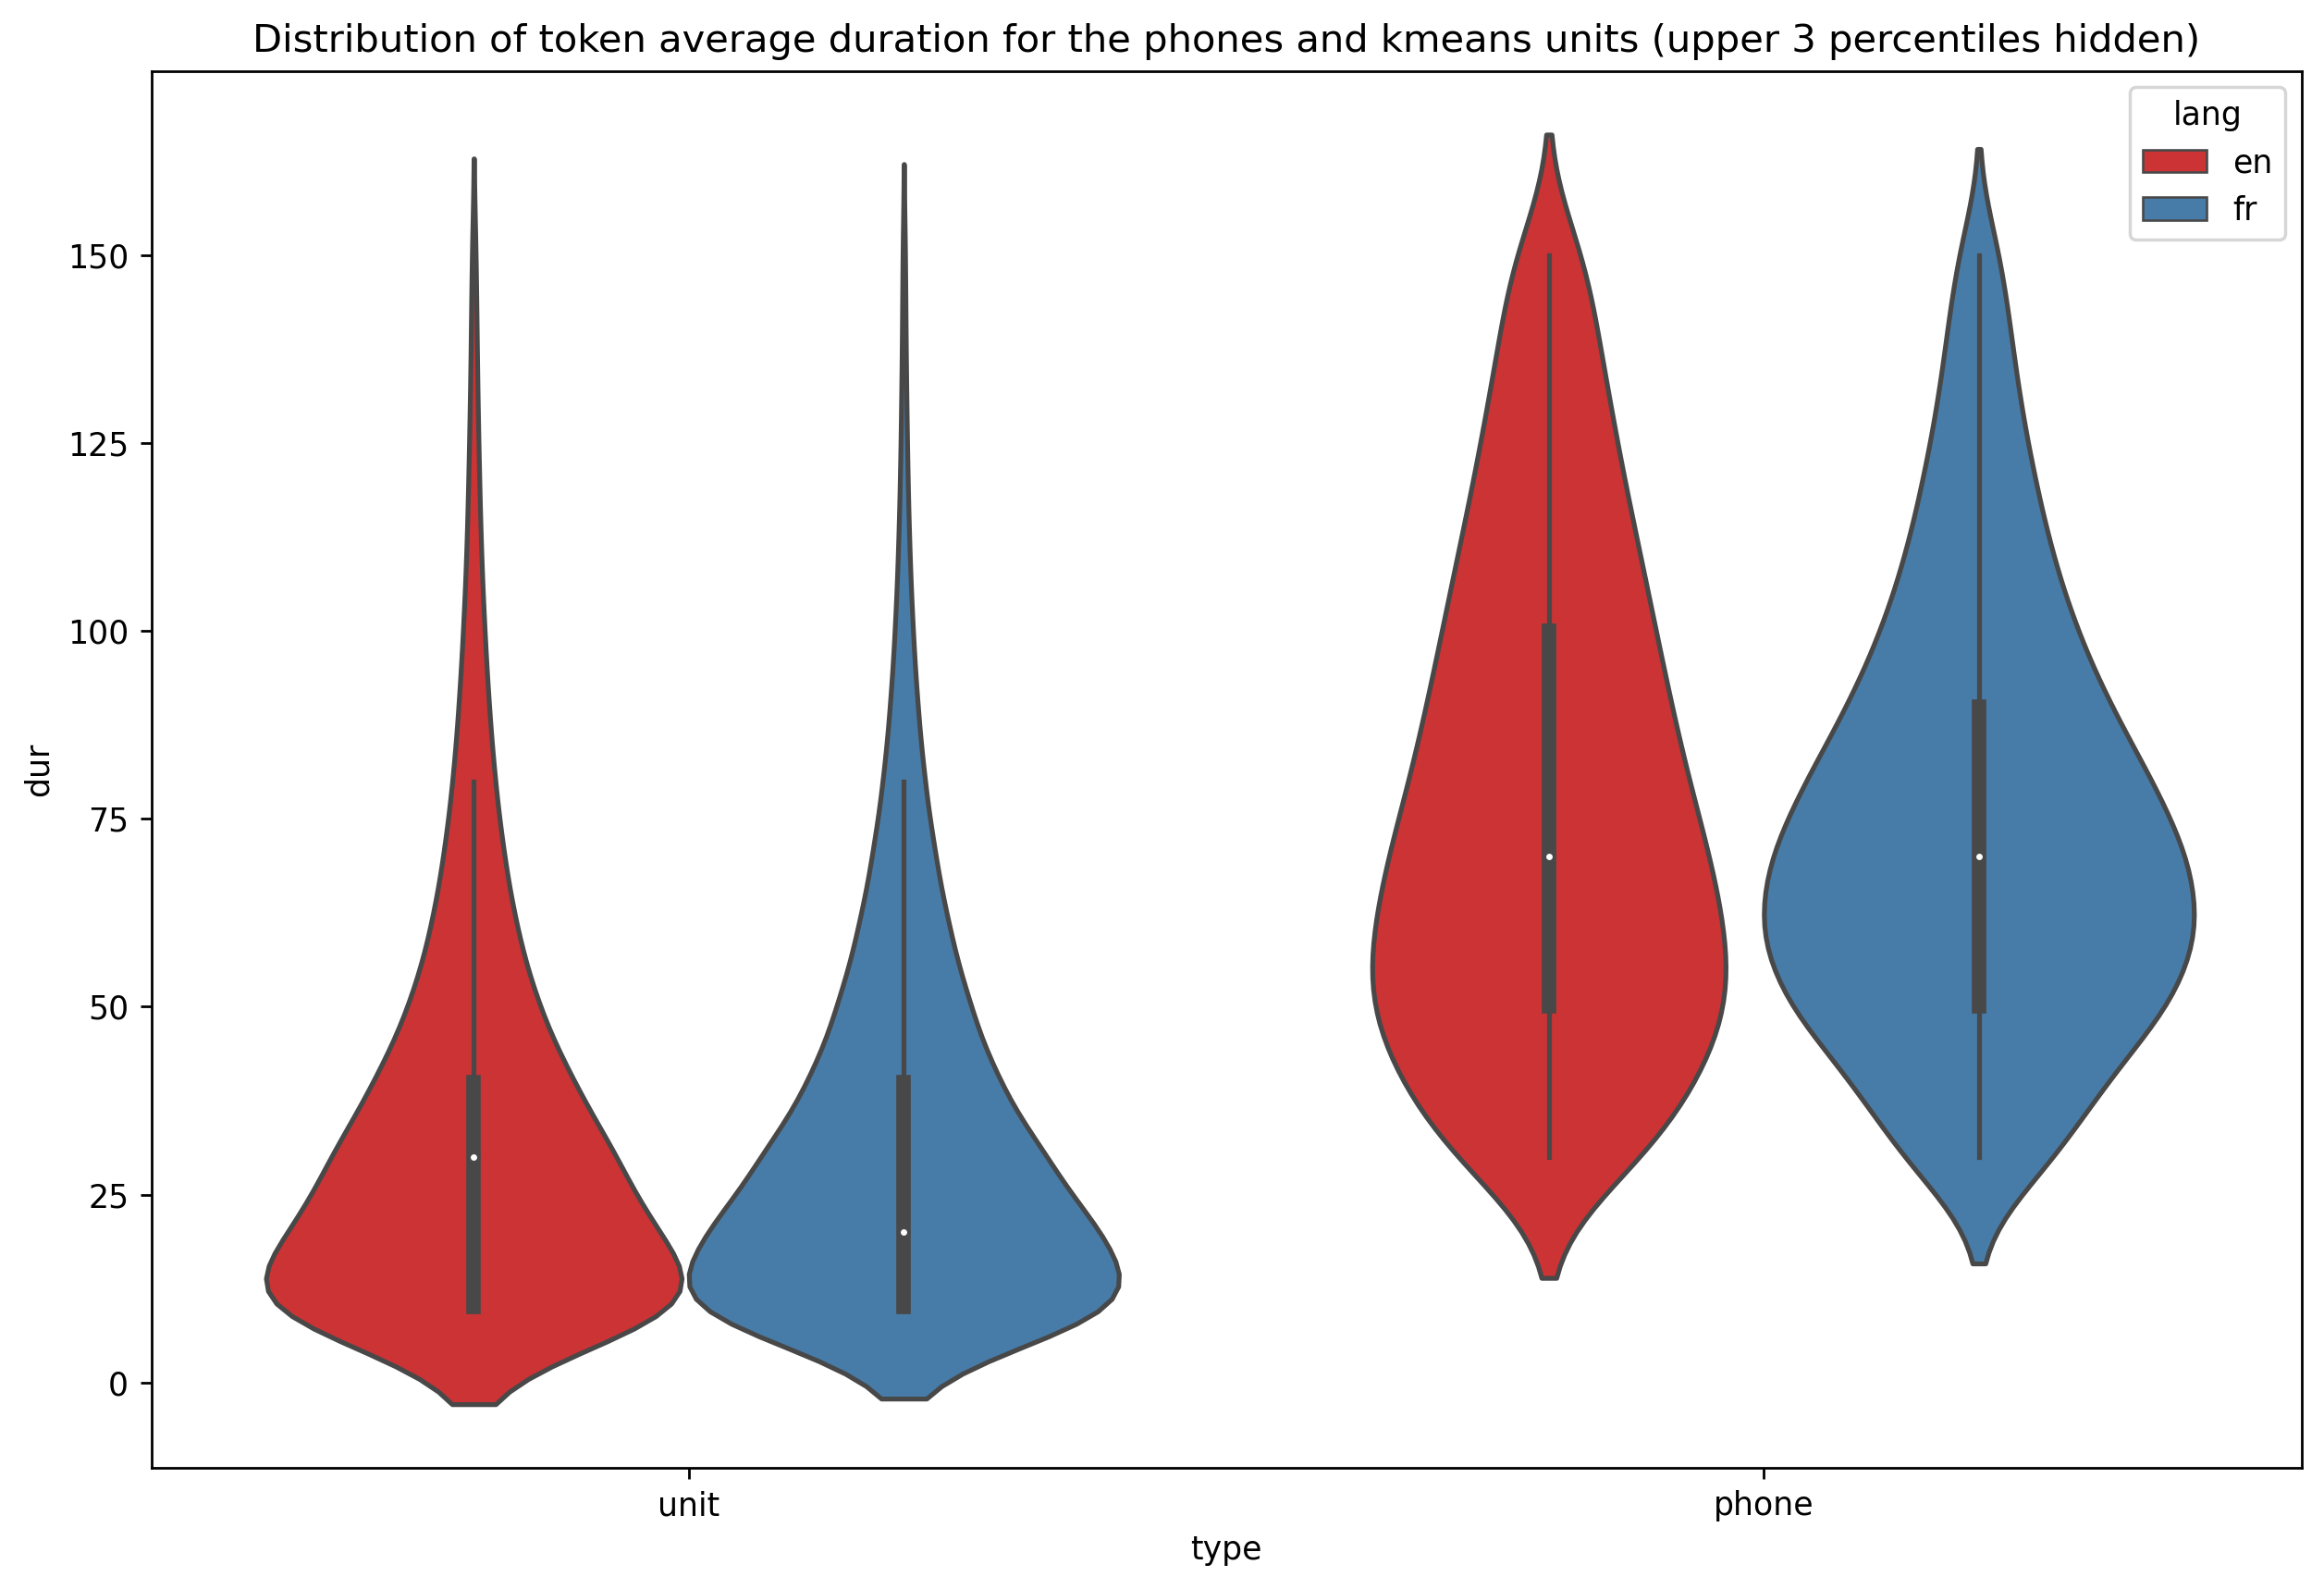

In [97]:

new_df = df_full[(df_full["dur"] < df_full["dur"].quantile(0.975))]
ax = sns.violinplot(x="type", y="dur", hue="lang", data=new_df, palette="Set1",bw=0.25)
ax.set_title('Distribution of token average duration for the phones and kmeans units (upper 3 percentiles hidden)')



Text(0.5, 1.0, 'Distribution of token average duration for the phones and kmeans units (upper 3 percentiles hidden)')

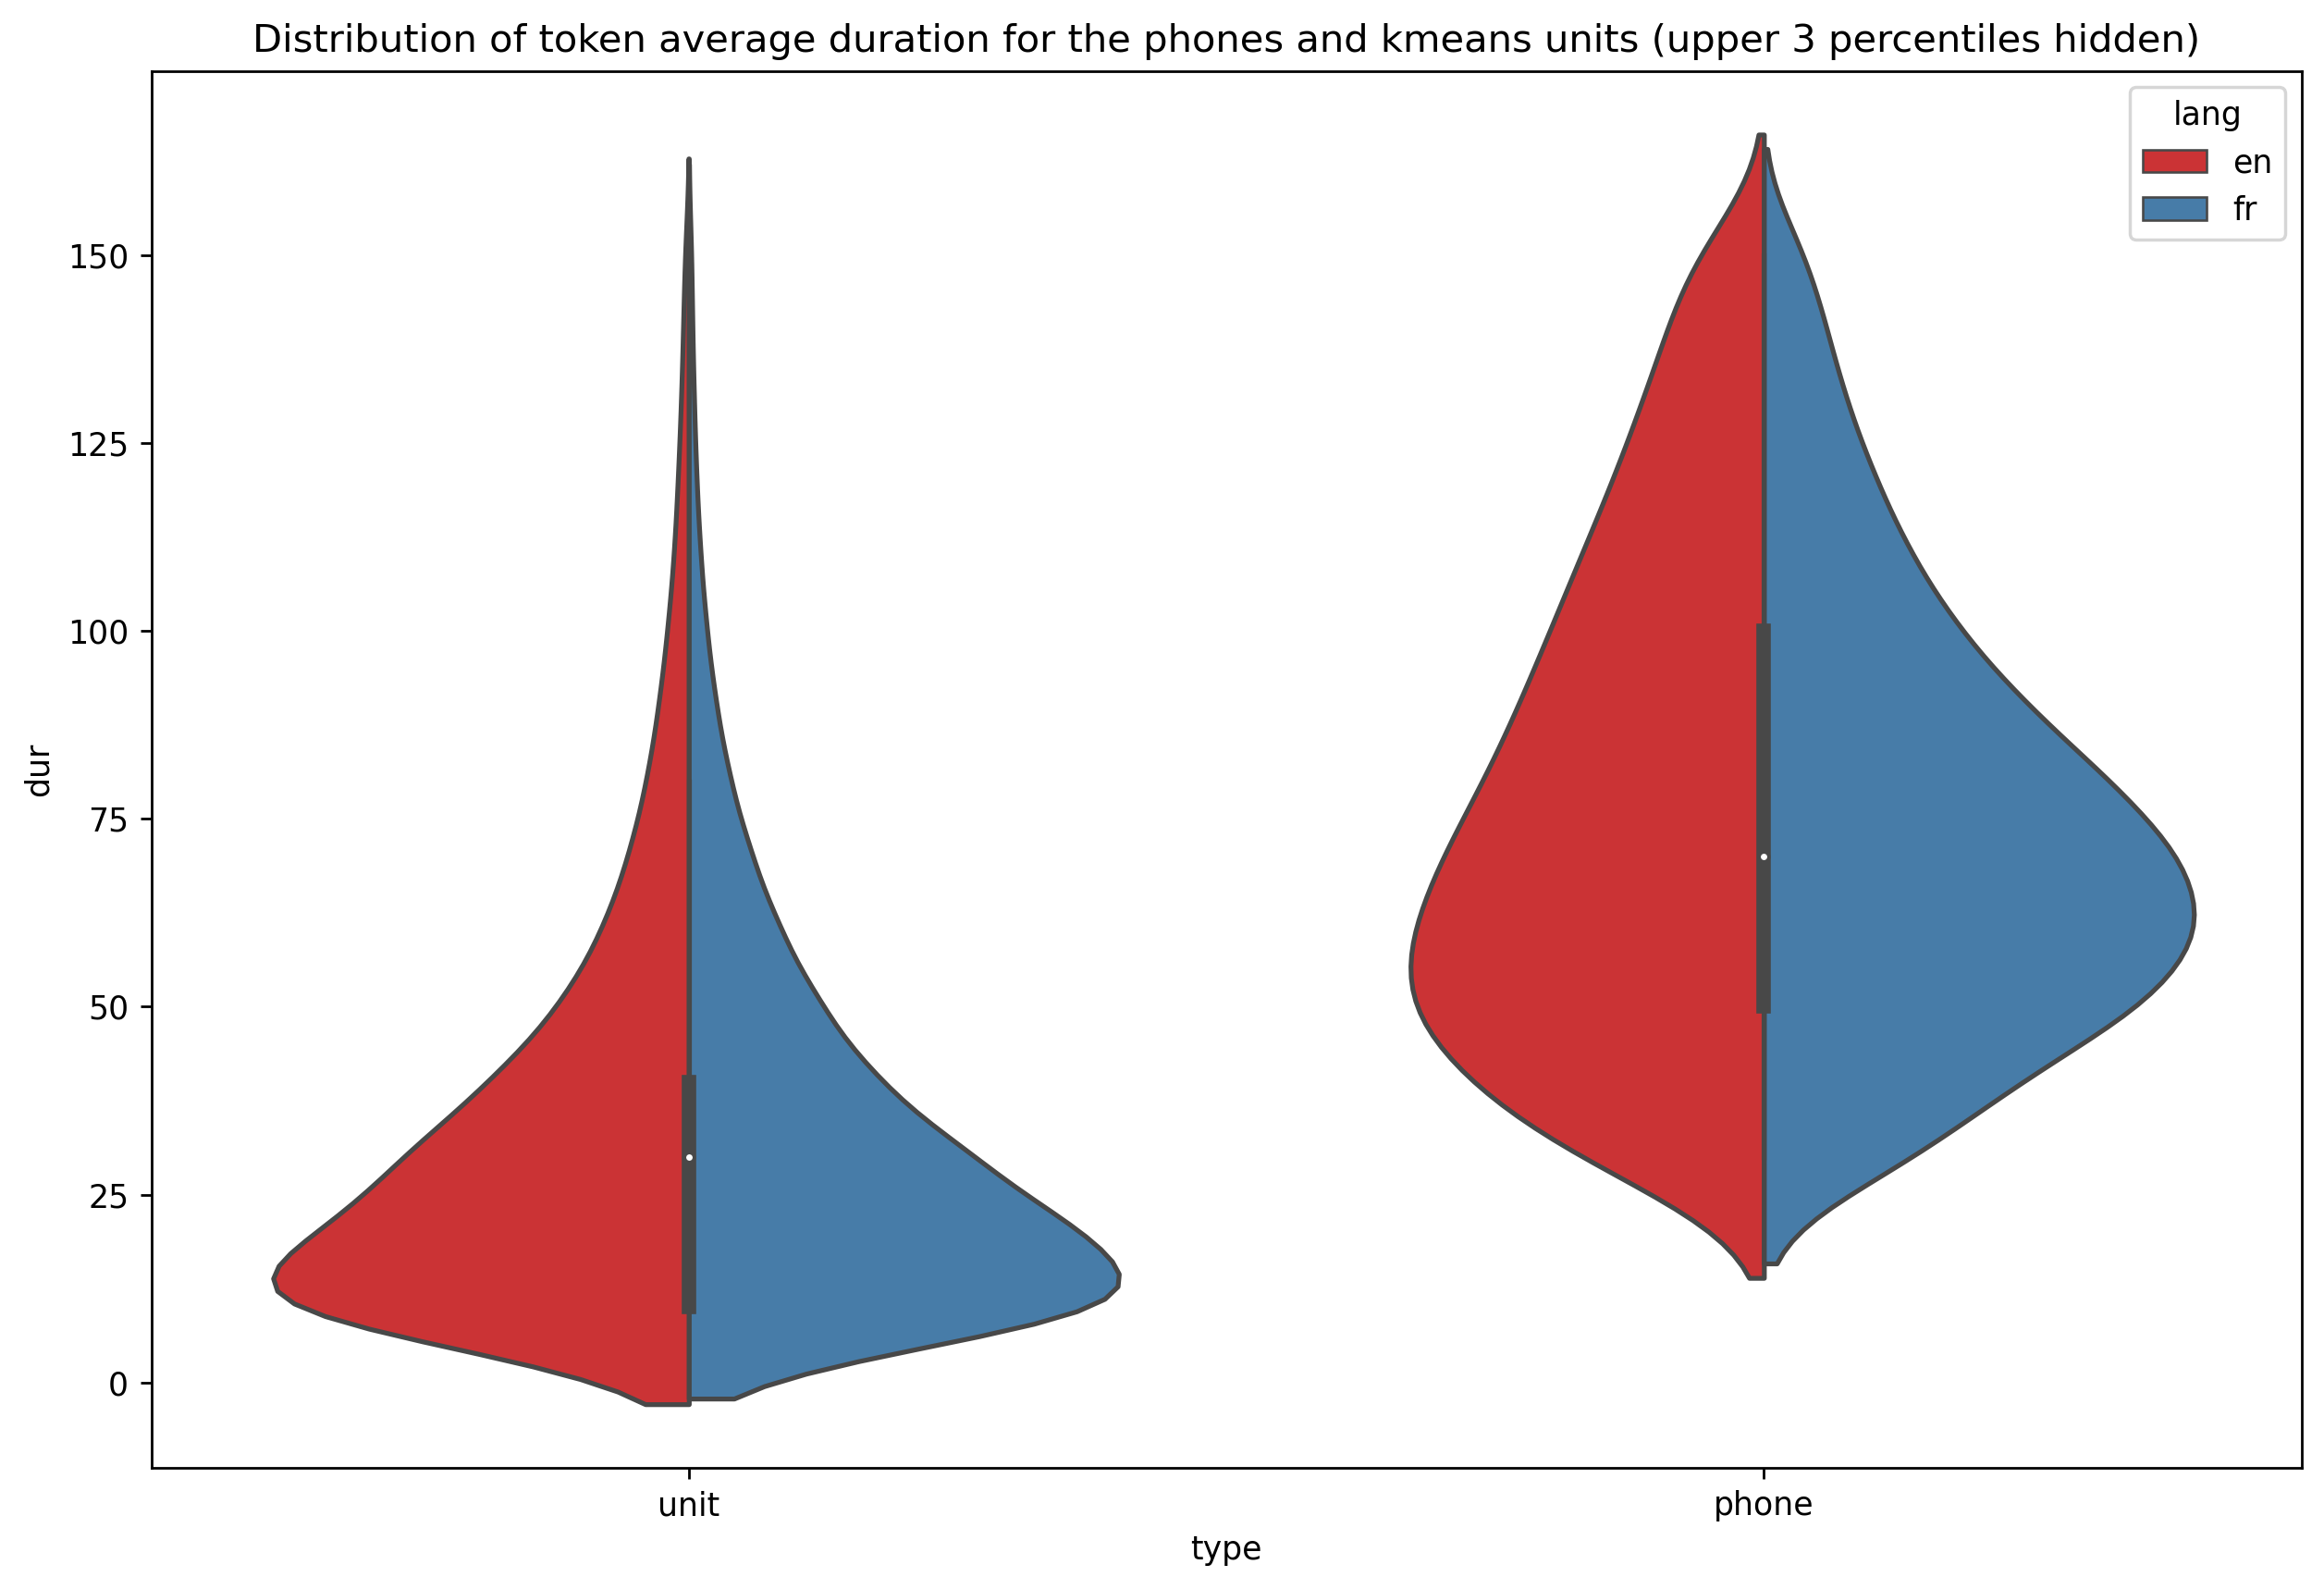

In [99]:

new_df = df_full[(df_full["dur"] < df_full["dur"].quantile(0.975))]
ax = sns.violinplot(x="type", y="dur", hue="lang", data=new_df, bw=0.25, palette="Set1", split=True)
ax.set_title('Distribution of token average duration for the phones and kmeans units (upper 3 percentiles hidden)')



Text(0.5, 1.0, 'Distribution of type average duration for the phones and kmeans units ')

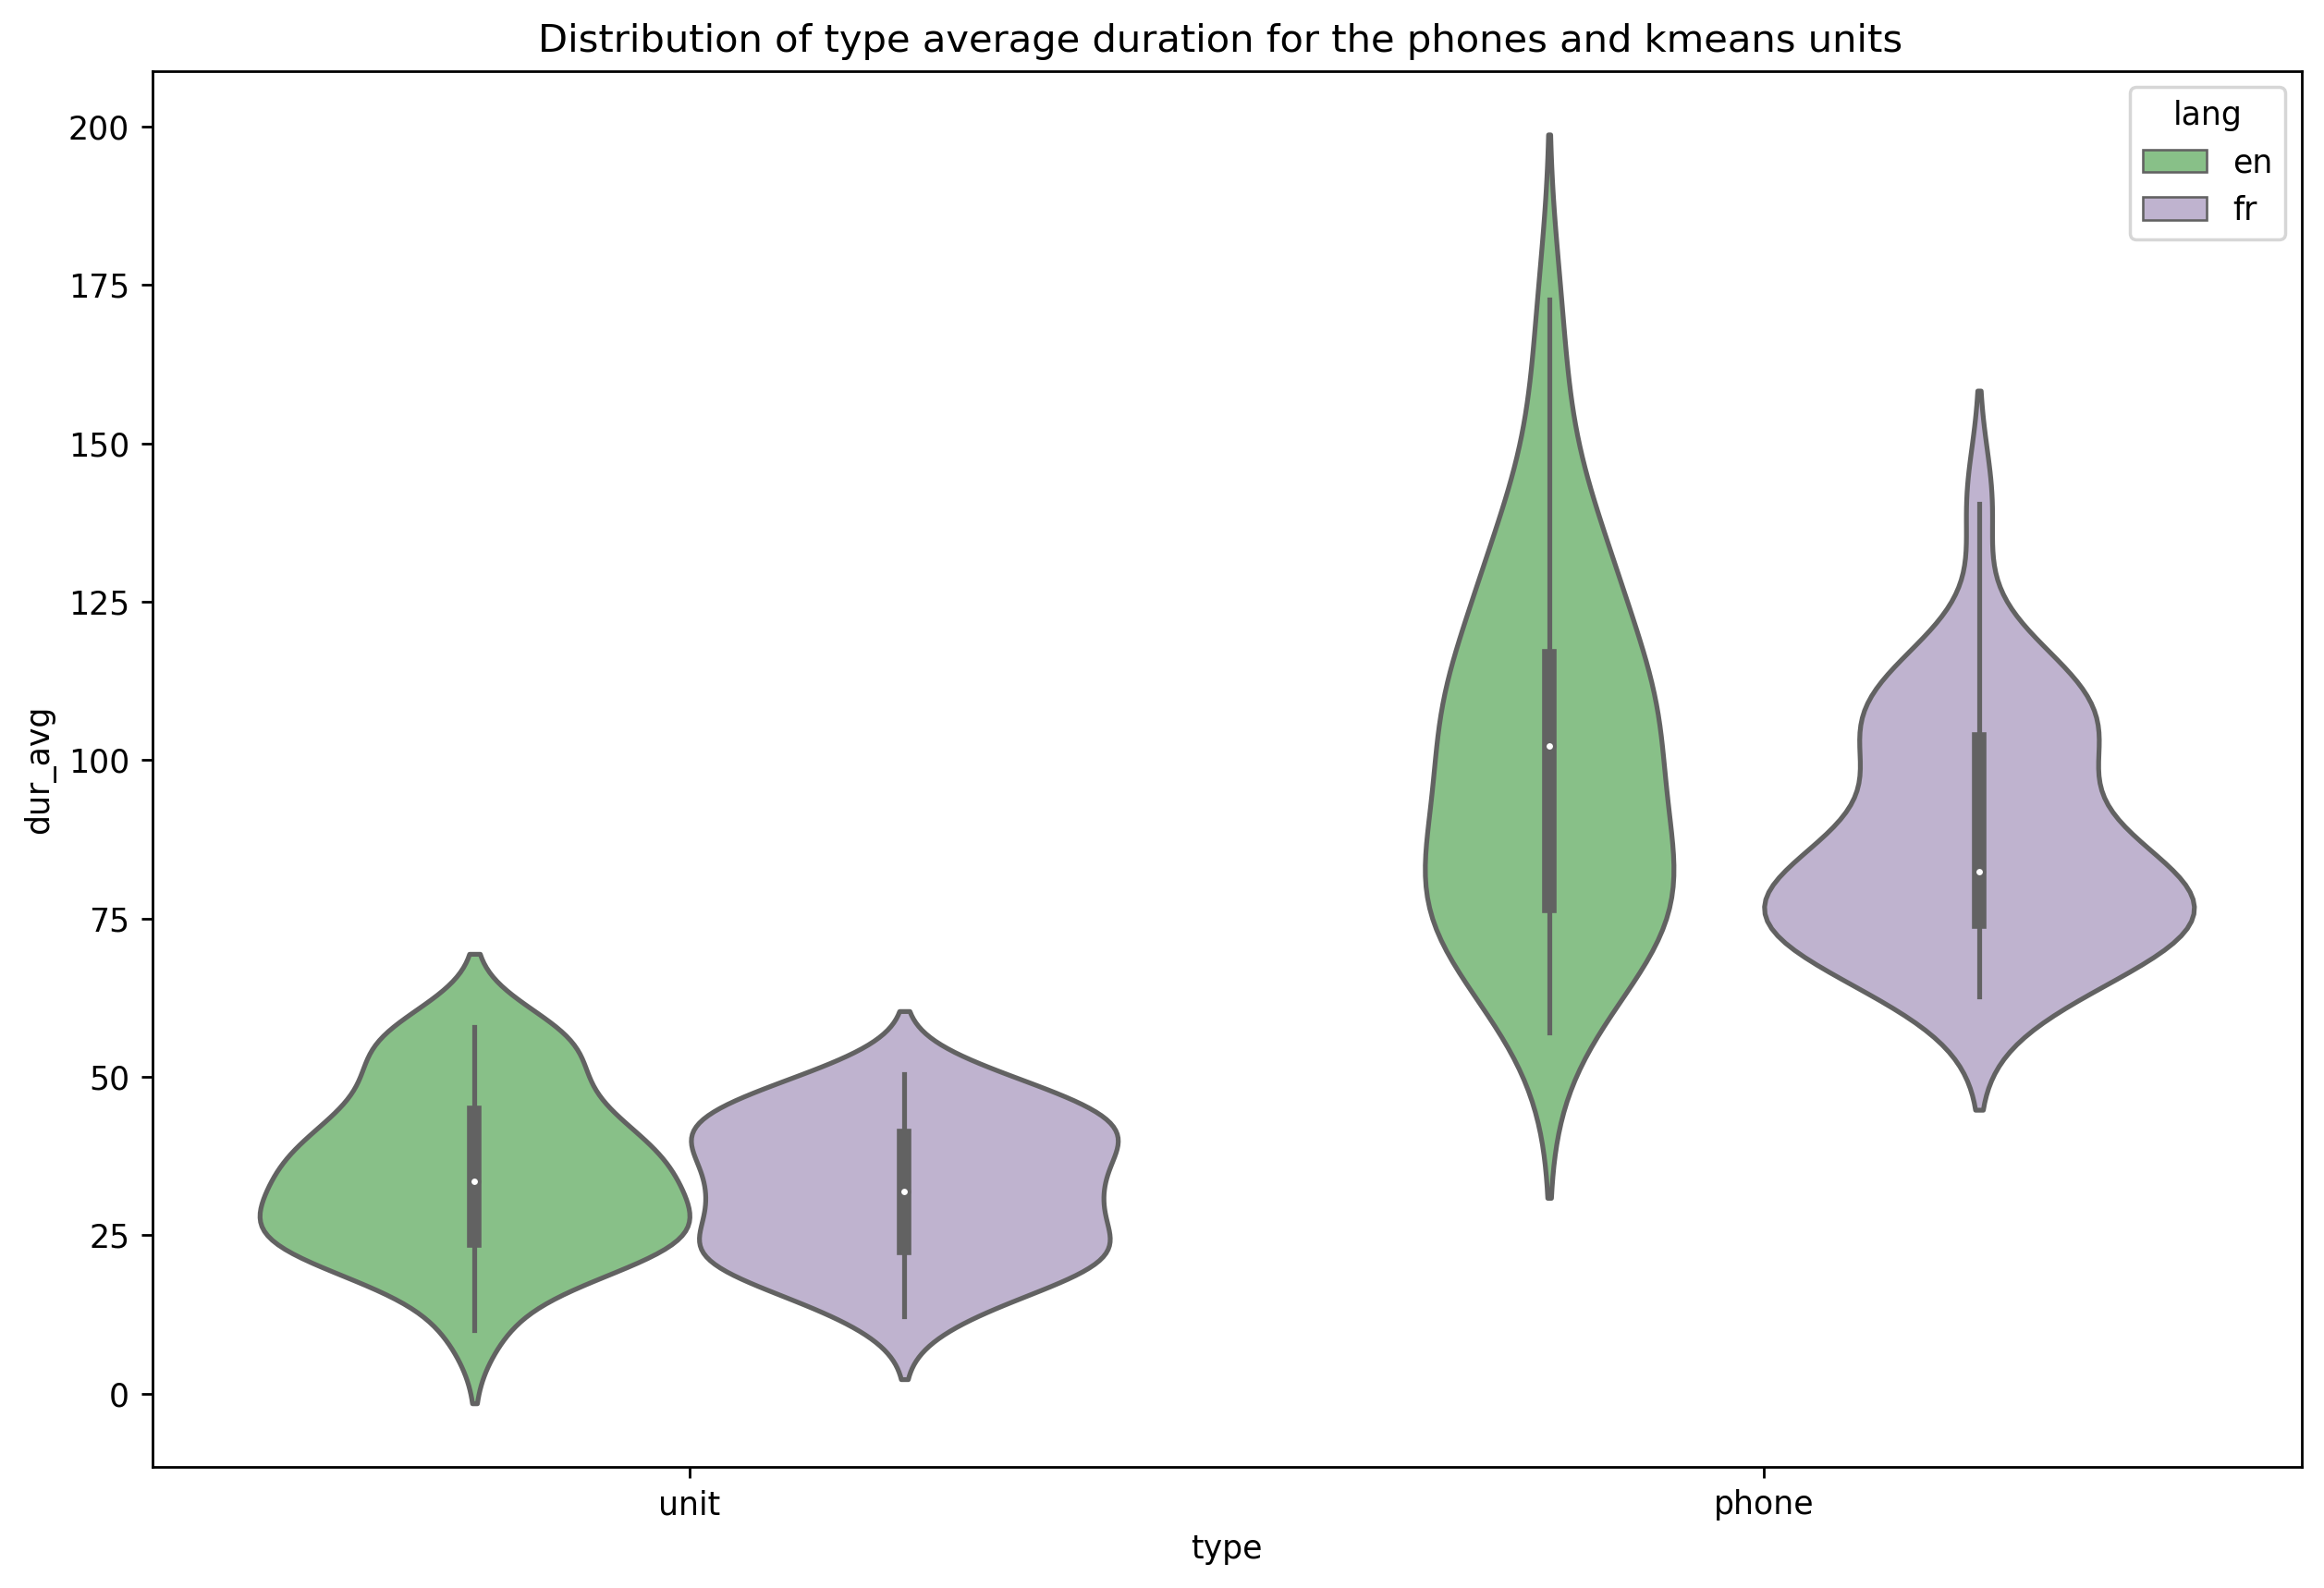

In [68]:
ax = sns.violinplot(x="type", y="dur_avg", hue="lang", data=df, palette="Accent")
ax.set_title('Distribution of type average duration for the phones and kmeans units ')



## additional analyses on Librispeech test set clean EN

In [112]:
#Quick additional analysis on LibriSpeech
lang="en"
km_units = "/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/eval/inftrain/{}/3200h/00/kmeans{}/{}_units_LS_clean.pkl".format(lang.upper(), NCLUSTER,lang)

w2u = pickle.load(open(km_units, "rb" ))
w2u  = correct_w2u(w2u)

df_units, df_units_full = get_units_df(w2u)

df = df_units
df_full=df_units_full
df['lang'] = lang
df_full['lang'] = lang
    

(0.0, 53000.0)

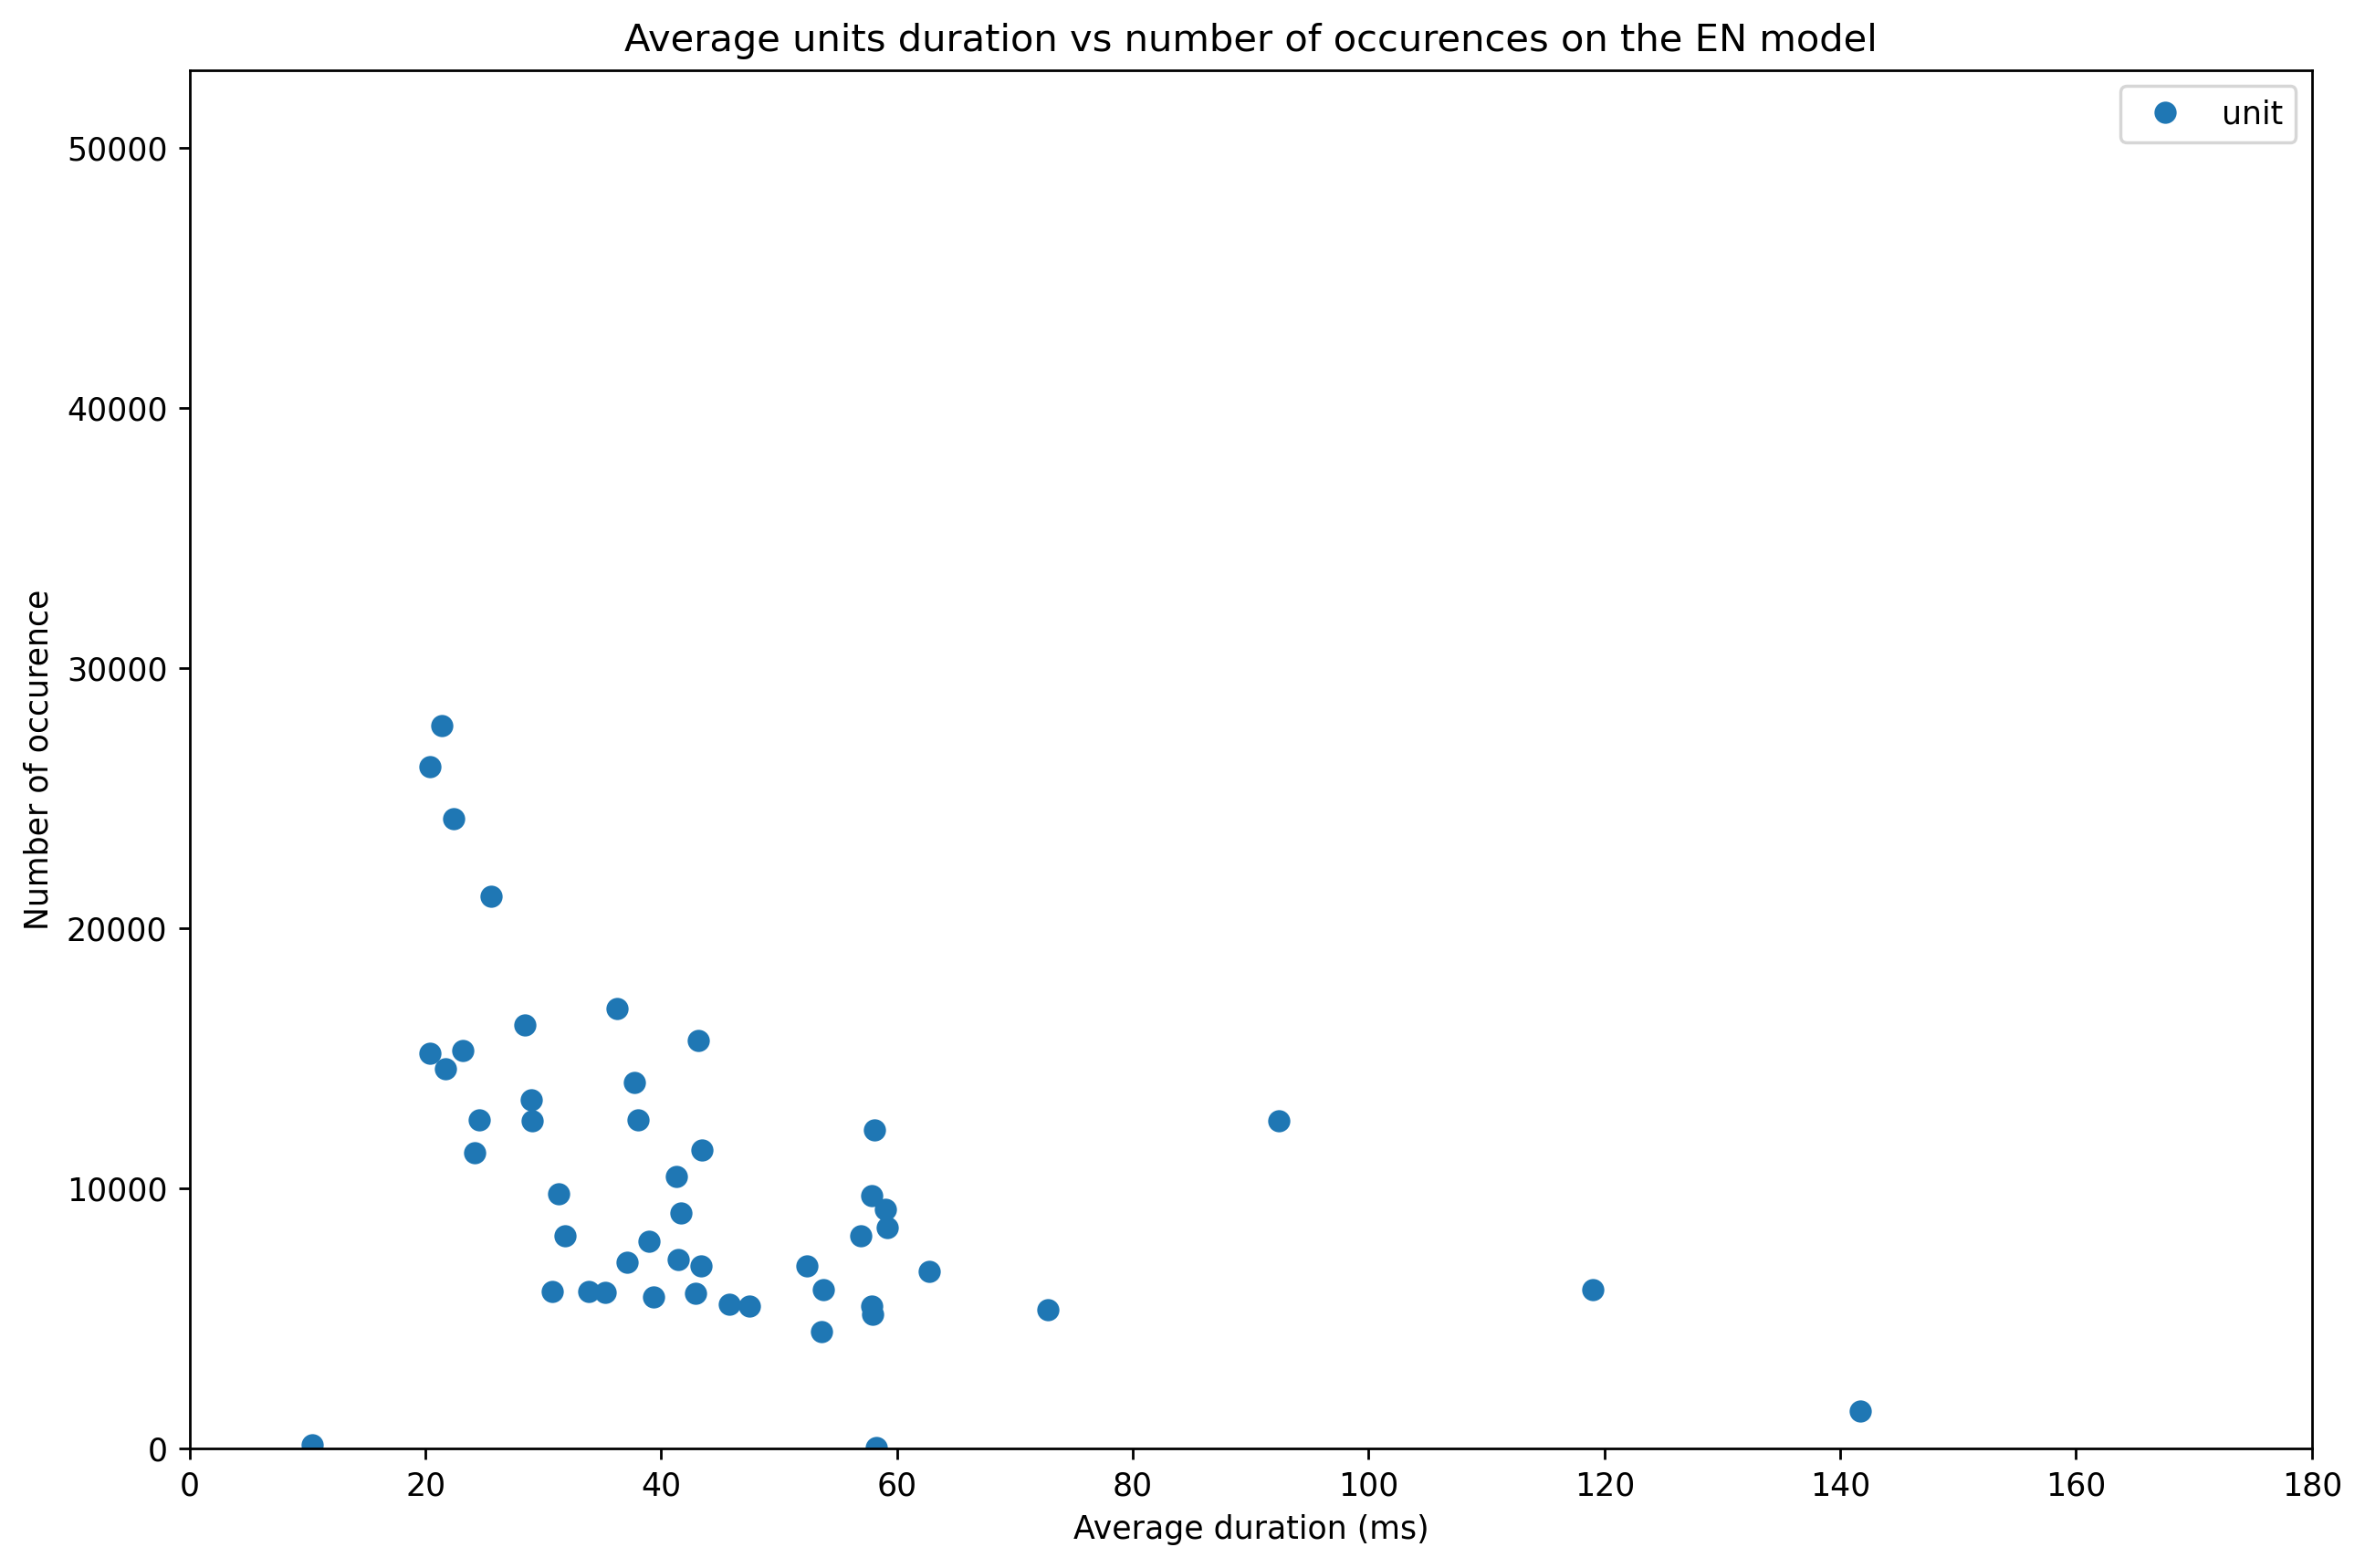

In [115]:
d = df

groups = d.groupby("type")
for name, group in groups:
    plt.plot(group["dur_avg"], group["num_items"], marker="o", linestyle="", label=name)
    
        
plt.legend()
plt.xlabel("Average duration (ms)")
plt.ylabel("Number of occurence")
plt.title("Average units duration vs number of occurences on the {} model".format(lang.upper()))

plt.xlim(0, 180)
plt.ylim(0, 53000)

Text(0.5, 1.0, 'Unit distribution in terms of #occurrences for the EN model on LIBRISPEECH EN TEST SET')

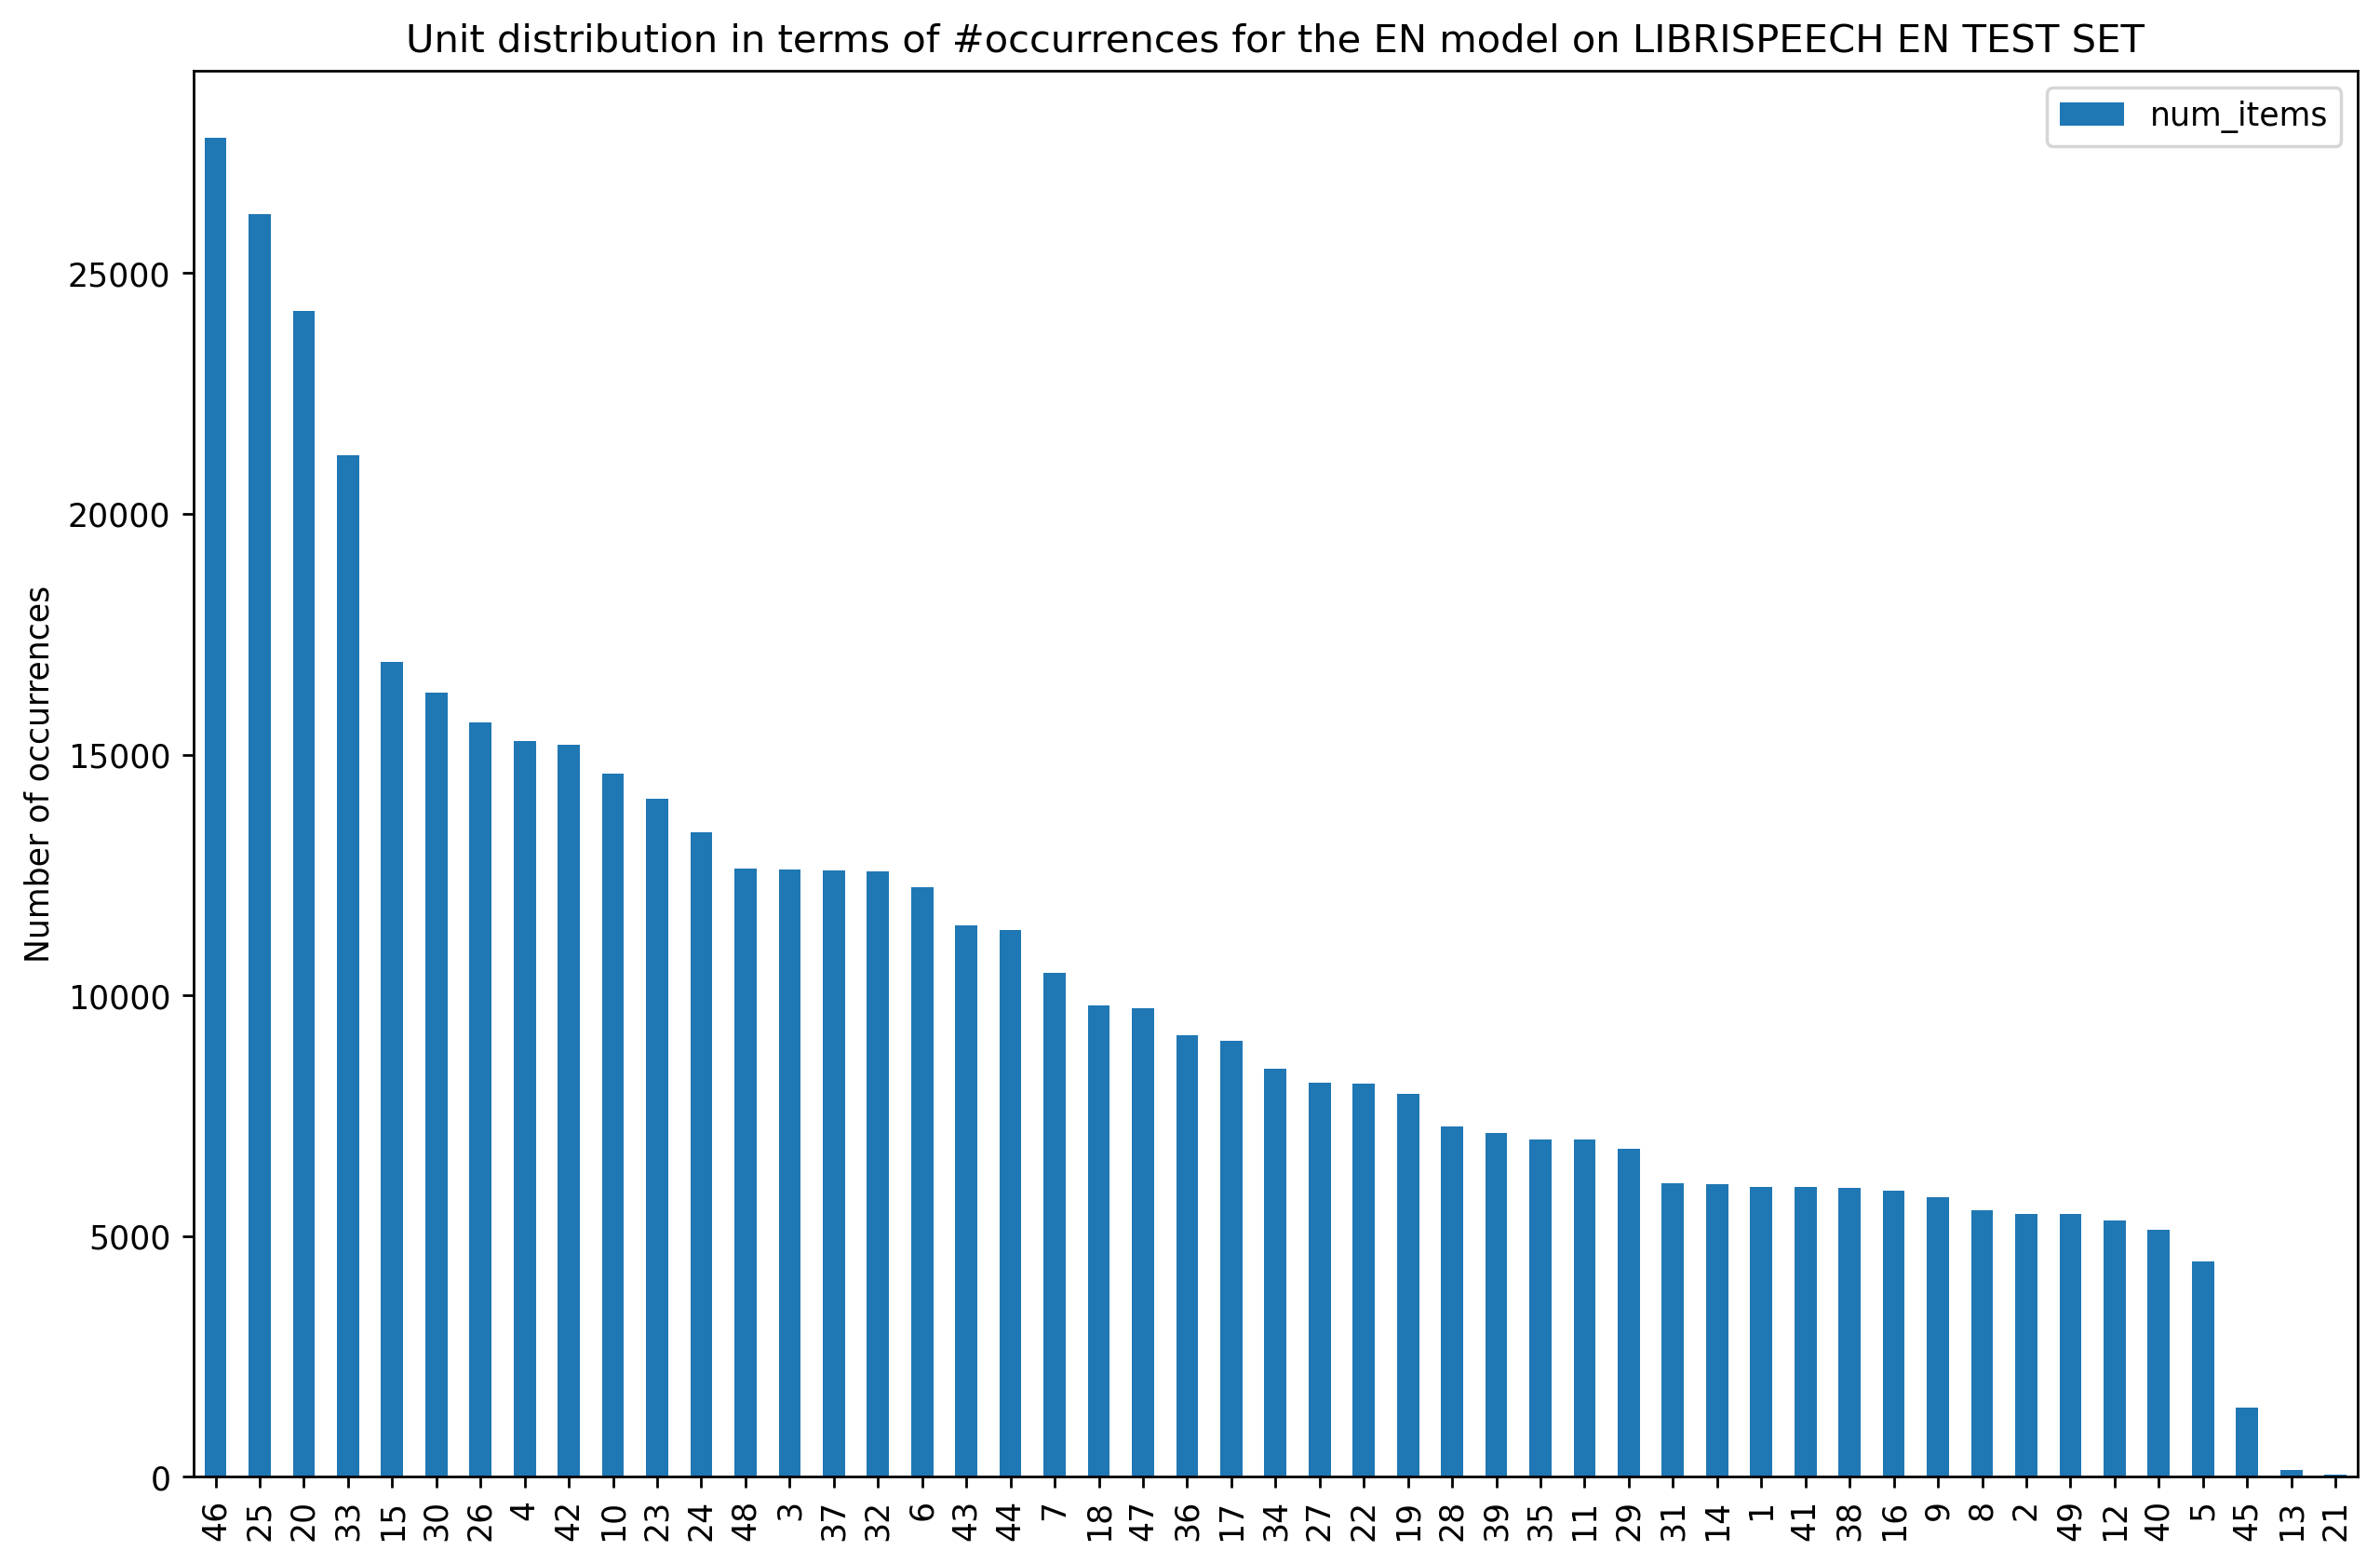

In [116]:
d = df

d[d['type']=='unit'].sort_values('num_items', ascending=False).plot.bar( y='num_items')
plt.ylabel("Number of occurrences")
plt.title('Unit distribution in terms of #occurrences for the {} model on LIBRISPEECH EN TEST SET'.format(lang.upper()))